## **Обработка данных**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import dill
import re
import time
import datetime
import geopy

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, mean_absolute_error, precision_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, HalvingGridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import lil_matrix

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### *Функции*

In [2]:
# возвращает True, если в строке содержится число
def get_digits(description):
    res = re.search(r'^\d+$', description)
    if res:
        return True

In [3]:
# выводит статистику по заполненности набора данных
def print_stats(df):
    print(f"Количество полностью заполненных объектов: {len(df.dropna())}")
    print(f"Процент полностью заполненных объектов: {round(len(df.dropna()) / (len(df) / 100), 2)}")

In [4]:
# выводит процент пропущенных значений
def print_missing_values(df):
    percent_missing = (df.isna().sum() / (len(df) / 100)).sort_values(ascending=False)
    print(f"Процент пропущенных значений:\n{percent_missing}")

In [5]:
# принимает датафрейм df с filling_col, где есть пропуски, и filled_col, по которой эти пропуски будут заполняться соответствующим самым часто встречаемым значением среди строк с заполненной filling_col
def change_nans(df, filled_col, filling_col):
    df_fill = df[~(df[filling_col].isna())]
    list_cols = list(df_fill[filled_col].unique())
    for col in list_cols:
        df.loc[((df[filled_col].isin(list_cols)) & (df[filling_col].isna())), filling_col] = df_fill[df_fill[filled_col] == col][filling_col].describe()['top']
    return df

In [6]:
# расчёт интерквантильного размаха
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

    return boundaries

In [7]:
# проверка вхождения метрики в границы нормальных значений
def get_and_check_min_max_bounds(data, str_metric):
    bounds = calculate_outliers(data[str_metric])
    
    if str(data[str_metric].dtype).find('int') >= 0:
        bounds = (int(round(bounds[0], 0)), int(round(bounds[1], 0)))

    if data[str_metric].min() >= bounds[0]:
        print("min входит в границы нормальных значений")
    else:
        print("min не входит в границы нормальных значений")
        
    if data[str_metric].max() <= bounds[1]:
        print("max входит в границы нормальных значений")
    else:
        print("max не входит в границы нормальных значений")
        
    return bounds

In [8]:
# принимает на вход df_data - датафрейм, в котором необходимо выделить в колонке column n самых часто встречаемых значений
def get_top(df_data, column, n=100):
    df_stat = df_data.groupby(column).agg({column: 'count'})
    df_stat = df_stat.rename(columns={column: 'count_' + column})
    
    df_stat = df_stat.sort_values(by='count_' + column, ascending=False)
    city_top = list(df_stat[df_stat['count_' + column] > n].index)

    return city_top

In [9]:
# принимает на вход data - датафрейм, в котором сокращается число значений в колонках list_cols по n самых часто встречаемых значений 
def trim_values_top(data, list_cols, n=100):
    for col in list_cols:
        new_col = col + '_short'
        list_top = get_top(data, col, n)
        data[new_col] = data[col].apply(lambda x: x if x in list_top else 'other')
        print("Число уникальных значений в новой колонке", new_col, ":", len(data[new_col].unique()))
    
    return data

In [10]:
# принимает на вход адрес adress и geolocator типа Nominatim, ожидает 5.5 секунд и запрашивает координаты локации
def get_location(adress: str, geolocator: Nominatim):
    time.sleep(5.5)
    location = geolocator.geocode(adress)
    
    return location

In [11]:
# принимает на вход data - датасет, в котором ищет и убирает выбросы
def trim_outliers(data):
    for q_value in data.columns: 
        print('Поиск выбросов признака', q_value)
        outliers = get_and_check_min_max_bounds(data, q_value)
        data.loc[(data[q_value] > outliers[1]), q_value] = outliers[1]
        data.loc[(data[q_value] < outliers[0]), q_value] = outliers[0]
        
    return data

In [12]:
# принимает на вход data - датасет, выводит точечный график, где data[x] - ордината, data[y] - абсцисса
def draw_figure_check_std(data, x, y):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
    
    ax1.scatter(data[x], data[y])
    ax1.set_title('Исходная')
    ax1.set_ylabel(y)
    ax1.set_xlabel(x)
    
    ax2.scatter(data[x + '_std'], data[y])
    ax2.set_title('После стандартизации')
    ax2.set_ylabel(y)
    ax2.set_xlabel(x)
    
    fig.suptitle(y + 'vs'+ x);

In [13]:
# принимает на вход data типа DataFrame, возвращает его данные в виде разреженной матрицы
def get_sparse_matrix_from_data(data):
    arr = lil_matrix(data.shape, dtype=np.float64)
    for i, col in enumerate(data.columns):
        ix = data[col] != 0
        arr[np.where(ix), i] = 1

    return arr.tocsr()

In [14]:
# вывод матриц ошибок для каждого значения целевой переменной
def print_multilabel_matrix(y_test, predict_test, labels):
    multi_matrix = multilabel_confusion_matrix(y_test, predict_test, labels=labels)
    for i in range(len(labels)): 
        print(f"Матрица ошибок для {labels[i]}: \n {multi_matrix[i]}")

In [15]:
# проверяем, переобучена ли модель
def check_training(cv_score):
    cv = cv_score.std() / cv_score.mean()
    if cv < 1.0:
        print(f"Коэффициент вариации = {cv}; Модель применима")
    else:
        print(f"Коэффициент вариации = {cv}; Модель переобучена")

### Data Preparation

##### Загрузка данных 

In [16]:
df_joined = 0
with open("data/ga_sessions.pkl", 'rb') as f:
    df_joined = dill.load(f)
df_joined.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [17]:
df_hits = pd.read_csv("data/ga_hits.csv")

df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [18]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


##### Добавление целевого столбца из ga_hits

На этом этапе, чтобы не растягивать размер датафрейма, сразу обработаем столбец ***event_action***, и поместим в датафрейм новый признак ***target_action***, больше соответствующий целям задачи, а именно принимающий значение 1, если ***event_action*** входит в список целевых действий, и 0, если не входит

In [19]:
target_actions = ['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click']

In [20]:
df_pa = df_hits[['session_id', 'event_action']]
df_pa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 2 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   session_id    object
 1   event_action  object
dtypes: object(2)
memory usage: 240.0+ MB


Сперва создаём новый признак

In [21]:
df_pa['target_action'] = df_pa['event_action'].apply(lambda x: 1 if x in target_actions else 0)
df_pa.head()

C:\Users\Fiore\AppData\Local\Temp\ipykernel_14316\3902168040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pa['target_action'] = df_pa['event_action'].apply(lambda x: 1 if x in target_actions else 0)


,session_id,event_action,target_action
0,5639623078712724064.1640254056.1640254056,quiz_show,0
1,7750352294969115059.1640271109.1640271109,quiz_show,0
2,885342191847998240.1640235807.1640235807,quiz_show,0
3,142526202120934167.1640211014.1640211014,quiz_show,0
4,3450086108837475701.1640265078.1640265078,quiz_show,0


Группируем результат по ***session_id***, суммируя ***target_action***, чтобы получить в ***df_group_pa*** число совершённых целевых действий. По условию все значения > 1 считаем как 1 

In [22]:
df_group_pa = df_pa.groupby(['session_id']).agg({'target_action': 'sum'})
df_group_pa.loc[(df_group_pa['target_action'] > 1), 'target_action'] = 1

In [23]:
df_group_pa['target_action'].value_counts()

0    1683850
1      50760
Name: target_action, dtype: int64

Образуем новый датасет из ***df_joined*** и ***df_group_pa***

In [24]:
df_joined = pd.merge(df_joined, df_group_pa, on='session_id')

df_joined

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target_action
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732261,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,Windows,None,NaN,1920x1080,Chrome,Russia,Moscow,0
1732262,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,None,Apple,NaN,390x844,Safari,Russia,Stavropol,0
1732263,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x667,Safari,Russia,Moscow,0
1732264,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Chelyabinsk,0


In [25]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1732266 entries, 0 to 1732265
Data columns (total 19 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
 18  target_action             int64 
dtypes: int64(2), object(17)
memory usage: 264.3+ MB


In [26]:
df_joined['target_action'].value_counts()

0    1681952
1      50314
Name: target_action, dtype: int64

In [27]:
print_stats(df_joined)

Количество полностью заполненных объектов: 13829
Процент полностью заполненных объектов: 0.8


In [28]:
print_missing_values(df_joined)

Процент пропущенных значений:
device_model                99.130503
utm_keyword                 58.925823
device_os                   58.533966
utm_adcontent               17.557177
utm_campaign                11.273500
device_brand                 6.358030
utm_source                   0.004387
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
target_action                0.000000
dtype: float64


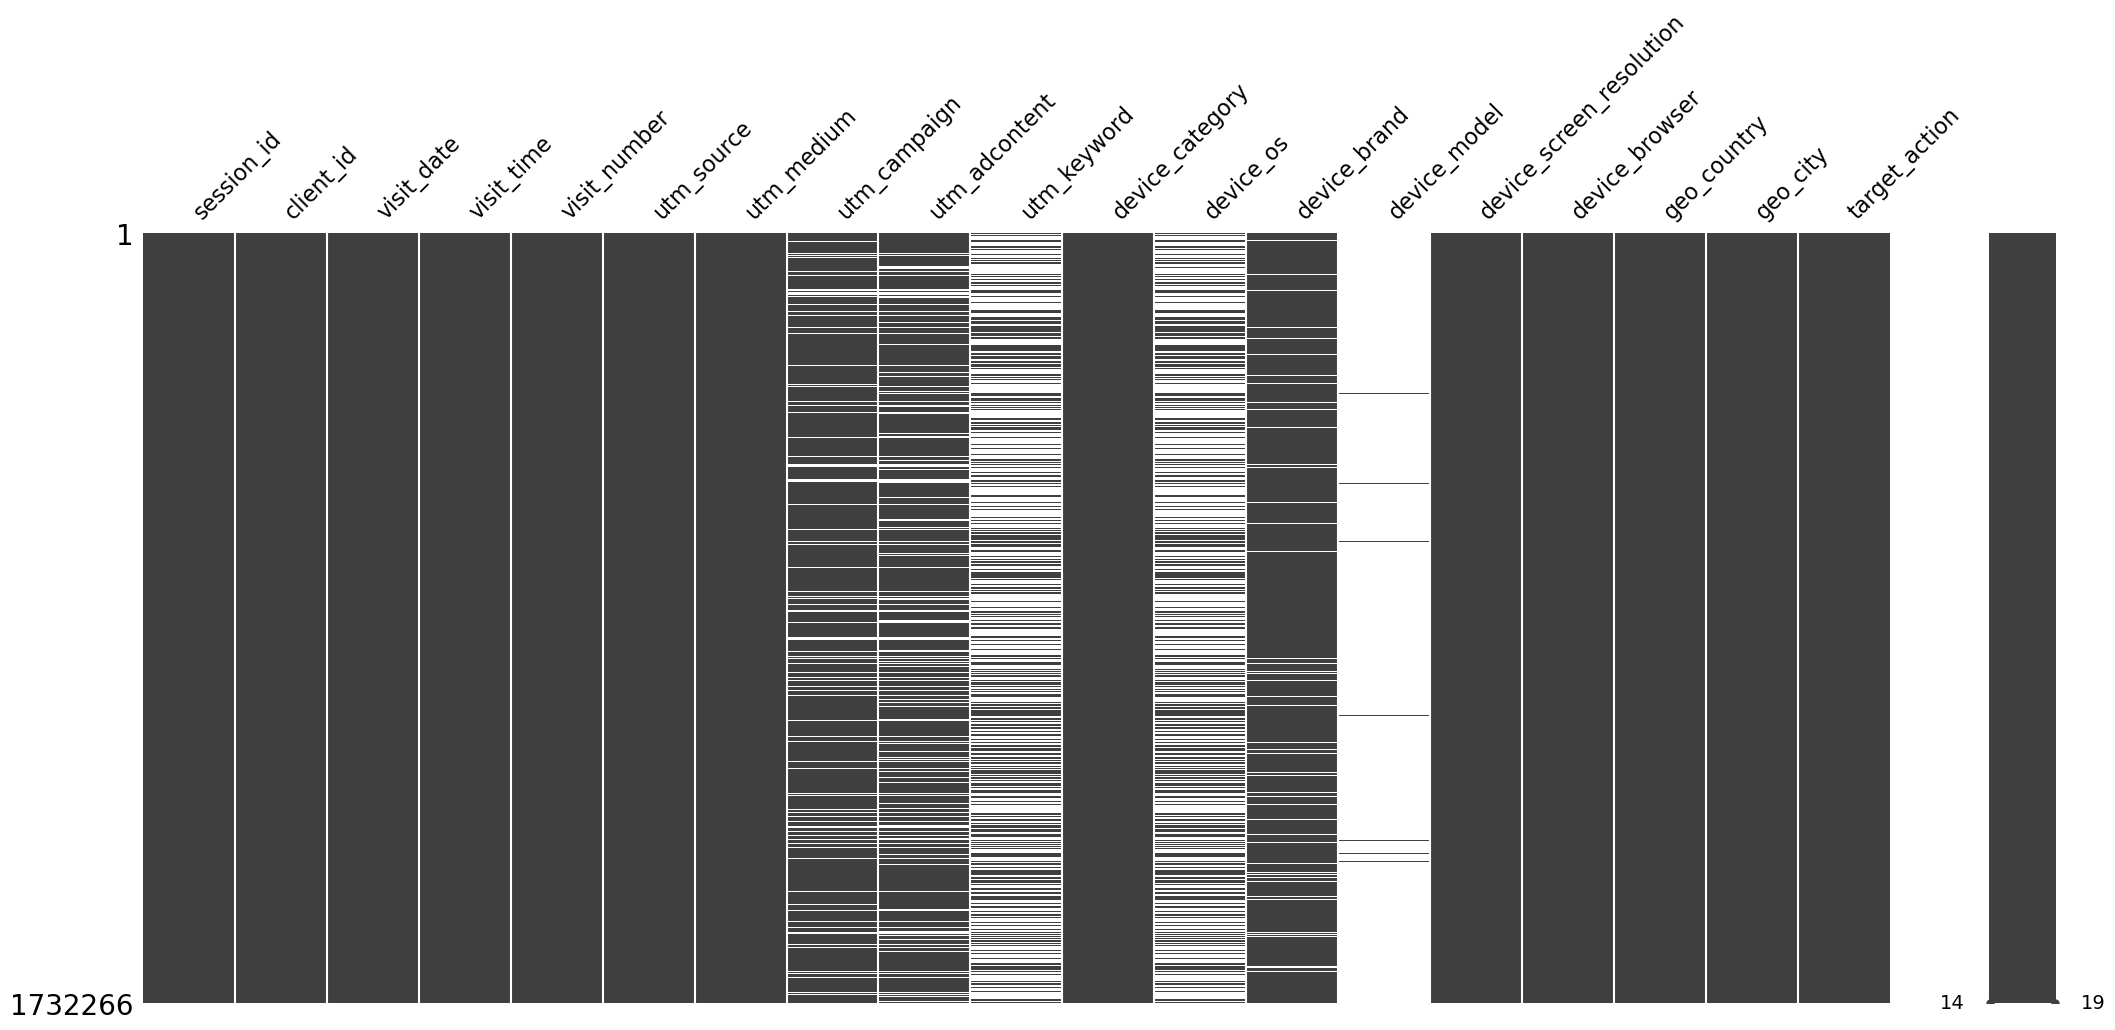

In [29]:
msno.matrix(df_joined);

Наблюдаем, что device_model практически пустой, utm_keyword и device_os заполнены лишь наполовину, и если device_os можно восстановить по более заполненному device_brand, то в device_model и utm_keyword содержится информация, которую логически не восстановить. Эти столбцы удаляем сразу

In [30]:
df_joined = df_joined.drop(columns=['device_model', 'utm_keyword'])

##### Обработка пропусков utm_source

Для начала уберём пропуски из фичи, которую можно будет использовать для заполнения пустых данных в других признаках 

In [31]:
df_joined.loc[(df_joined['utm_source'].isna())].shape

(76, 17)

In [32]:
df_joined = df_joined.loc[~(df_joined['utm_source'].isna())]

In [33]:
print_missing_values(df_joined)

Процент пропущенных значений:
device_os                   58.536535
utm_adcontent               17.555869
utm_campaign                11.273994
device_brand                 6.355538
device_category              0.000000
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
client_id                    0.000000
utm_medium                   0.000000
utm_source                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
target_action                0.000000
dtype: float64


##### Обработка пропусков device_brand

Бренд можно точно определить по специфическим браузерам и ОС. Впоследствии эта фича поможет нам устранить пропуски в данных о модели и ОС

In [34]:
# маска для неопределённого device_brand - not set, пустая строка и NaN
mask_undef_brand = (df_joined['device_brand'] == '(not set)') | (df_joined['device_brand'] == '') | (df_joined['device_brand'].isna())

In [35]:
df_joined.loc[mask_undef_brand & ((df_joined['device_browser'] == 'Safari') | (df_joined['device_browser'] == '[FBAN') | (df_joined['device_browser'].str.contains('Safari'))), 'device_brand']  = 'Apple'

In [37]:
df_joined.loc[mask_undef_brand & (df_joined['device_browser'] == 'Samsung Internet'), 'device_brand'] = 'Samsung'

In [38]:
df_joined.loc[mask_undef_brand & (df_joined['device_category'] == 'desktop') & (df_joined['device_os'] == 'Macintosh'), 'device_brand'] = 'Apple'

In [39]:
df_joined[mask_undef_brand]['device_browser'].unique()

array(['Chrome', 'YaBrowser', 'Safari', 'Firefox', 'Opera', 'Edge',
       'helloworld', 'Android Webview', 'Samsung Internet',
       'Instagram 208.0.0.32.135 Android', 'Mozilla Compatible Agent',
       '(not set)', 'Mozilla', 'Coc Coc', 'Android',
       'Instagram 216.1.0.21.137 Android', '[FBAN', 'Internet Explorer',
       'MRCHROME', 'Opera Mini', 'com.vk.vkclient',
       'Instagram 209.0.0.21.119 Android',
       'Instagram 213.0.0.29.120 Android', 'Puffin',
       'Instagram 199.1.0.34.119 Android', 'Maxthon', 'SeaMonkey',
       'Instagram 194.0.0.36.172 Android', 'UC Browser',
       'Instagram 202.0.0.37.123 Android',
       'Instagram 192.0.0.35.123 Android',
       'Instagram 212.0.0.38.119 Android', 'Android Browser',
       'Instagram 158.0.0.30.123 Android', 'Android Runtime', 'Konqueror',
       'Threads 202.0.0.23.119'], dtype=object)

Приложение Threads закрыто в 2021-м году, поэтому данные, где оно используется, не пригодятся нам в анализе. Удаляем их

In [41]:
df_joined = df_joined[~(df_joined['device_browser'].str.contains('Threads'))]

In [42]:
df_joined[(df_joined['device_brand'].isna())]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_action
28,9055505230298952295.1638478433.1638478433,2108399111.1638478439,2021-12-02,23:53:53,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1536x864,Chrome,Russia,Balashikha,0
65,9055678214400253418.1636965866.1636965866,2108439387.1636965866,2021-11-15,11:44:26,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1920x1080,Chrome,Russia,Saint Petersburg,0
77,9055795561498027164.1638278300.1638278300,2108466709.1638278300,2021-11-30,16:18:20,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,desktop,Windows,None,1680x1050,Chrome,Russia,Moscow,0
86,9055853019573035768.1640801016.1640801016,2108480087.1640801016,2021-12-29,21:03:36,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1024x820,YaBrowser,Russia,Moscow,0
96,9055873197324118026.1635526668.1635526668,2108484785.1635526666,2021-10-29,19:57:48,1,jaSOmLICuBzCFqHfBdRg,email,bxOTvPtyGSdUrbwoXCPO,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1920x1080,YaBrowser,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732224,9055247549438461124.1635878086.1635878086,2108339115.1635878084,2021-11-02,21:34:46,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1366x768,Chrome,Russia,Kazan,0
1732233,9055283330814105899.1638979884.1638979890,2108347446.1638979883,2021-12-08,19:11:30,1,bByPQxmDaMXgpHeypKSM,referral,QdLfySaGXolfTBSNVfHn,SOkCdPxfUcZUzzOdgGES,desktop,Windows,None,1920x1080,Chrome,Russia,Krasnodar,0
1732250,9055354507009984602.1636829278.1636829278,2108364018.1636829274,2021-11-13,21:47:58,1,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,desktop,Windows,None,1366x768,Firefox,Russia,Balashikha,0
1732261,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,desktop,Windows,None,1920x1080,Chrome,Russia,Moscow,0


In [43]:
df_joined[(df_joined['device_brand'].isna())]['device_os'].unique()

array(['Windows', 'Linux', '(not set)', 'Chrome OS', 'Macintosh'],
      dtype=object)

In [44]:
df_joined[(df_joined['device_brand'].isna())]['device_os'].describe()

count       86606
unique          5
top       Windows
freq        81731
Name: device_os, dtype: object

In [45]:
df_joined.loc[((df_joined['device_brand'].isna()) & (df_joined['device_category'] == 'desktop'))]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_action
28,9055505230298952295.1638478433.1638478433,2108399111.1638478439,2021-12-02,23:53:53,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1536x864,Chrome,Russia,Balashikha,0
65,9055678214400253418.1636965866.1636965866,2108439387.1636965866,2021-11-15,11:44:26,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1920x1080,Chrome,Russia,Saint Petersburg,0
77,9055795561498027164.1638278300.1638278300,2108466709.1638278300,2021-11-30,16:18:20,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,desktop,Windows,None,1680x1050,Chrome,Russia,Moscow,0
86,9055853019573035768.1640801016.1640801016,2108480087.1640801016,2021-12-29,21:03:36,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1024x820,YaBrowser,Russia,Moscow,0
96,9055873197324118026.1635526668.1635526668,2108484785.1635526666,2021-10-29,19:57:48,1,jaSOmLICuBzCFqHfBdRg,email,bxOTvPtyGSdUrbwoXCPO,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1920x1080,YaBrowser,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732224,9055247549438461124.1635878086.1635878086,2108339115.1635878084,2021-11-02,21:34:46,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1366x768,Chrome,Russia,Kazan,0
1732233,9055283330814105899.1638979884.1638979890,2108347446.1638979883,2021-12-08,19:11:30,1,bByPQxmDaMXgpHeypKSM,referral,QdLfySaGXolfTBSNVfHn,SOkCdPxfUcZUzzOdgGES,desktop,Windows,None,1920x1080,Chrome,Russia,Krasnodar,0
1732250,9055354507009984602.1636829278.1636829278,2108364018.1636829274,2021-11-13,21:47:58,1,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,desktop,Windows,None,1366x768,Firefox,Russia,Balashikha,0
1732261,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,desktop,Windows,None,1920x1080,Chrome,Russia,Moscow,0


In [46]:
df_joined.loc[mask_undef_brand & (df_joined['device_category'] == 'desktop') & (df_joined['device_os'] != 'Macintosh'), 'device_brand'] = 'other'

In [47]:
df_joined.loc[(df_joined['device_brand'].isna())]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_action
110999,128743428747935717.1638907878.1638907878,29975415.1638907877,2021-12-07,23:11:18,1,kjsLglQLzykiRbcDiGcD,cpc,XHNUiSKKGTEpSAlaVMFQ,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,393x851,Chrome,Russia,(not set),0
113019,1296701003971072834.1637258051.1637258051,301911729.1637258050,2021-11-18,20:54:11,1,kjsLglQLzykiRbcDiGcD,cpc,UjApcvnaHtkydRkrLYuv,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,851x393,Chrome,Russia,Moscow,0
128144,1371041858455442706.1636723488.1636723488,319220558.1634571538,2021-11-12,16:24:48,6,kjsLglQLzykiRbcDiGcD,cpc,nSReTmyFtbSjlPrTKoaX,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,424x942,Chrome,Russia,Nizhny Novgorod,0
247507,1946178047144129078.1638953526.1638953526,453129887.1638953526,2021-12-08,11:52:06,1,kjsLglQLzykiRbcDiGcD,cpc,WlbWUObZWvsimzdFdLYw,JNHcPlZPxEMWDnRiyoBf,mobile,Windows,None,1920x1080,Edge,Russia,Moscow,0
257199,1993060007474941190.1637141768.1637141768,464045444.1637141766,2021-11-17,12:36:08,1,kjsLglQLzykiRbcDiGcD,cpc,UjApcvnaHtkydRkrLYuv,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,360x720,Chrome,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556181,8213511827182896805.1639303366.1639303366,1912357245.1639237285,2021-12-12,13:02:46,2,kjsLglQLzykiRbcDiGcD,cpc,UjApcvnaHtkydRkrLYuv,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,393x830,Chrome,Russia,Saint Petersburg,0
1587509,8365118374521985765.1635375847.1635375847,1947655895.1635375845,2021-10-28,02:04:07,1,kjsLglQLzykiRbcDiGcD,cpc,xhbLYKykcxmylecTsBop,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,1600x1200,Chrome,India,Gurgaon,0
1598353,8416888273925634168.1635580025.1635580025,1959709514.1635580024,2021-10-30,10:47:05,1,kjsLglQLzykiRbcDiGcD,cpc,xhbLYKykcxmylecTsBop,JNHcPlZPxEMWDnRiyoBf,tablet,Linux,None,1600x1200,Chrome,India,Gurgaon,0
1606091,8453794644430050718.1636119335.1636119335,1968302448.1633310110,2021-11-05,16:35:35,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,Linux,None,412x915,Chrome,Russia,Saint Petersburg,0


In [48]:
df_joined[(df_joined['device_brand'].isna())]['device_os'].unique()

array(['Linux', 'Windows', 'Macintosh'], dtype=object)

In [49]:
df_joined.loc[((df_joined['device_brand'].isna()) & (df_joined['device_os'] == 'Macintosh')), 'device_brand'] = 'Apple'

In [50]:
df_joined.loc[(df_joined['device_brand'].isna()), 'device_os'].unique()

array(['Linux', 'Windows'], dtype=object)

In [51]:
df_joined[(df_joined['device_brand'] == '(not set)')]['device_browser'].unique()

array(['Chrome', 'Firefox', 'Opera', 'YaBrowser', 'Android Webview',
       'Mozilla', 'Opera Mini', 'com.vk.vkclient', 'UC Browser',
       'Android Browser', 'Android Runtime', 'Internet Explorer'],
      dtype=object)

In [52]:
df_joined.loc[(df_joined['device_brand'].isna()), 'device_brand'] = 'other'

In [53]:
df_joined[(df_joined['device_brand'] == '(not set)')]['device_os'].unique()

array([None, 'Android', '(not set)'], dtype=object)

In [54]:
df_joined[(df_joined['device_brand'] == '(not set)')]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_action
80,9055834796008808950.1622811129.1622811129,2108475844.1622811126,2021-06-04,15:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,None,(not set),360x640,Chrome,Russia,Chelyabinsk,0
122,9056013556852379550.1632554912.1632554912,2108517465.1632554910,2021-09-25,10:00:00,1,RmEBuqrriAfAVsLQQmhk,cpc,VBmazutCflYumtDHrQYe,JNHcPlZPxEMWDnRiyoBf,mobile,None,(not set),342x741,Firefox,Russia,Kazan,0
157,9056202067269505745.1640092368.1640092368,2108561356.1640092369,2021-12-21,16:12:48,1,ZpYIoDJMcFzVoPFsHGJL,push,sbJRYgVfvcnqKJNDDYIr,JNHcPlZPxEMWDnRiyoBf,mobile,Android,(not set),384x854,Chrome,Russia,Moscow,0
199,9056422519349747445.1638964982.1638964982,2108612684.1638964981,2021-12-08,15:03:02,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,(not set),320x640,Chrome,Russia,Saint Petersburg,0
200,9056422519349747445.1638966940.1638966940,2108612684.1638964981,2021-12-08,15:35:40,2,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,(not set),320x640,Chrome,Russia,Saint Petersburg,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731295,9051046216723789689.1635186553.1635186553,2107360916.1635186553,2021-10-25,21:29:13,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,(not set),320x570,Chrome,Russia,Kommunar,0
1731617,9052676375860711226.1639943995.1639943995,2107740467.1639943994,2021-12-19,22:59:55,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,(not set),393x873,Chrome,Russia,Izhevsk,0
1731854,9053730012943175107.1640761072.1640761072,2107985786.1640320451,2021-12-29,09:57:52,2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,(not set),360x760,Chrome,Russia,Vladivostok,0
1731966,9054179214979411516.1637002817.1637002817,2108090374.1637002812,2021-11-15,22:00:17,1,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,mobile,Android,(not set),396x858,Firefox,Russia,Saint Petersburg,0


In [55]:
df_joined.loc[(df_joined['device_brand'] == '(not set)'), 'device_category'].unique()

array(['mobile', 'tablet'], dtype=object)

In [56]:
df_joined.loc[((df_joined['device_brand'] == '(not set)') | (df_joined['device_brand'] == '')), 'device_brand'] = 'other'

In [57]:
print_missing_values(df_joined)

Процент пропущенных значений:
device_os                   58.536511
utm_adcontent               17.555879
utm_campaign                11.274001
device_category              0.000000
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
device_brand                 0.000000
session_id                   0.000000
client_id                    0.000000
utm_medium                   0.000000
utm_source                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
target_action                0.000000
dtype: float64


##### Обработка пропущенных значений device_os

In [58]:
df_joined['device_os'].describe()

count      718226
unique         13
top       Android
freq       425499
Name: device_os, dtype: object

Запоминаем отдельно самые часто встречающиеся значения для каждой категории средит заполненных данных

In [59]:
top_OSes = dict()
for category in list(df_joined['device_category'].unique()):
    top_OSes[category] = df_joined[~(df_joined['device_os'].isna())].loc[(df_joined['device_category'] == category), 'device_os'].describe()['top']
print(top_OSes)

{'mobile': 'Android', 'tablet': 'Android', 'desktop': 'Windows'}


In [60]:
df_joined[df_joined['device_os'].isna()].shape

(1013963, 17)

Во многих случаях случаях device_os зависит от device_brand, и в этих записях мы точно можем заполнить отсутствующие значения

In [61]:
df_joined.loc[(df_joined['device_brand'] == 'Apple'), 'device_os'].describe()

count     205966
unique         2
top          iOS
freq      182590
Name: device_os, dtype: object

In [62]:
df_joined.loc[(df_joined['device_brand'] == 'Apple'), 'device_os'].unique()

array([None, 'iOS', 'Macintosh'], dtype=object)

In [63]:
df_joined.loc[(df_joined['device_brand'] == 'Apple'), 'device_category'].unique()

array(['mobile', 'tablet', 'desktop'], dtype=object)

In [66]:
# маска для неопределённой ОС
mask_undef_os = (df_joined['device_os'].isna()) | (df_joined['device_os'] == '(not set)') | (df_joined['device_os'] == '')

Для всех мобильных устройств бренда Apple, у которых не определена ОС, задать iOS, для desktop - Macintosh

In [68]:
df_joined.loc[((df_joined['device_brand'] == 'Apple') & ((df_joined['device_category'] == 'mobile') | (df_joined['device_category'] == 'tablet')) & mask_undef_os), 'device_os']  = 'iOS'

In [69]:
df_joined.loc[((df_joined['device_brand'] == 'Apple') & (df_joined['device_category'] == 'desktop') & mask_undef_os), 'device_os']  = 'Macintosh'

In [70]:
df_joined.loc[(df_joined['device_brand'] == 'Apple'), 'device_os'].unique()

array(['iOS', 'Macintosh'], dtype=object)

Посмотрим на бренд Blackberry

In [71]:
df_joined.loc[(df_joined['device_brand'] == 'BlackBerry'), 'device_os'].unique()

array([None, 'Android', 'BlackBerry'], dtype=object)

In [72]:
df_joined.loc[((df_joined['device_brand'] == 'BlackBerry') & (df_joined['device_os'] == 'BlackBerry'))].shape

(24, 17)

In [73]:
df_joined.loc[(df_joined['device_brand'] == 'BlackBerry'), 'device_os'].describe()

count          84
unique          2
top       Android
freq           60
Name: device_os, dtype: object

BlackBerry OS - достаточно редкая в текущее время система, и при анализе она не окажет существенного влияния на результат, поэтому заполняем пустые device_os для этого бренда значением самой часто встречаемой ОС  

In [74]:
df_joined.loc[(df_joined['device_brand'] == 'BlackBerry'), 'device_os'] = top_OSes['mobile']

In [75]:
df_joined.loc[(df_joined['device_brand'] != 'Apple'), 'device_os'].unique()

array(['Android', None, 'Windows', 'Linux', '(not set)', 'Chrome OS',
       'Tizen', 'Firefox OS', 'Nokia', 'Samsung', 'Windows Phone'],
      dtype=object)

Возьмём заполненные данные и вытащим из них список всех остальных брендов

In [76]:
df_os_fill = df_joined[~(df_joined['device_brand'].isna()) & ~(df_joined['device_brand'].isna())]
df_os_fill.shape

(1732189, 17)

In [77]:
list_brands_m = df_os_fill.loc[((df_os_fill['device_os'] == top_OSes['mobile']) & (df_os_fill['device_category'] == 'mobile')), 'device_brand'].unique()
list_brands_t = df_os_fill.loc[((df_os_fill['device_os'] == top_OSes['tablet']) & (df_os_fill['device_category'] == 'tablet')), 'device_brand'].unique()

In [78]:
df_joined.loc[((df_joined['device_brand'].isin(list(list_brands_m))) & (df_joined['device_category'] == 'mobile') & mask_undef_os), 'device_os'] = top_OSes['mobile']
df_joined.loc[((df_joined['device_brand'].isin(list(list_brands_t))) & (df_joined['device_category'] == 'tablet') & mask_undef_os), 'device_os'] = top_OSes['tablet']

Теперь проверяем характеристики device_browser и device_category

In [79]:
df_joined.loc[(df_joined['device_os'].isna()), 'device_browser'].unique()

array(['YaBrowser', 'Chrome', 'Safari', 'Firefox', 'Opera', 'Edge',
       'Instagram 208.0.0.32.135 Android', '(not set)',
       'Mozilla Compatible Agent', 'Coc Coc', 'Samsung Internet',
       'Android', '[FBAN', 'Instagram 209.0.0.21.119 Android', 'Puffin',
       'Internet Explorer', 'MRCHROME',
       'Instagram 199.1.0.34.119 Android', 'SeaMonkey',
       'Instagram 194.0.0.36.172 Android',
       'Instagram 202.0.0.37.123 Android', 'Mozilla',
       'Instagram 192.0.0.35.123 Android', 'Maxthon', 'Android Webview',
       'MT6735_TD', 'Instagram 158.0.0.30.123 Android', 'UC Browser',
       'Konqueror'], dtype=object)

Встроенные браузеры так же позволяют однозначно определить систему

In [80]:
df_joined.loc[(((df_joined['device_browser'] == 'Safari') | (df_joined['device_browser'] == '[FBAN') | (df_joined['device_browser'].str.contains('Safari'))) 
                & df_joined['device_os'].isna() & (df_joined['device_category'] == 'desktop')), 'device_os'] = 'Macintosh'

In [81]:
df_joined.loc[(((df_joined['device_browser'] == 'Safari') | (df_joined['device_browser'] == '[FBAN') | (df_joined['device_browser'].str.contains('Safari'))) 
                & df_joined['device_os'].isna() & (df_joined['device_category'] != 'desktop')), 'device_os'] = 'iOS'

In [82]:
df_joined.loc[(df_joined['device_os'].isna() & (df_joined['device_browser'] == 'Samsung Internet')), 'device_os'] = 'Android'

In [83]:
df_joined.loc[(df_joined['device_os'].isna() & ((df_joined['device_browser'] == 'Edge') | (df_joined['device_browser'] == 'Internet Explorer'))), 'device_os'] = 'Windows'

In [84]:
df_joined.loc[(df_joined['device_os'].isna() & (df_joined['device_browser'].str.contains('Android'))), 'device_os'] = 'Android' 

In [85]:
df_joined.loc[(df_joined['device_browser'] == 'Mozilla Compatible Agent'), 'device_category'].unique()

array(['desktop'], dtype=object)

In [86]:
df_joined.loc[(df_joined['device_browser'] == 'Mozilla Compatible Agent'), 'device_os'].describe()

count           285
unique            3
top       (not set)
freq            256
Name: device_os, dtype: object

In [87]:
df_joined.loc[(df_joined['device_browser'] == 'Mozilla Compatible Agent'), 'device_brand'].describe()

count       336
unique        2
top       other
freq        320
Name: device_brand, dtype: object

In [88]:
df_joined.loc[(df_joined['device_browser'] == 'Mozilla Compatible Agent')]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_action
7930,9093064959820033783.1637871353.1637871353,2117144167.1637871351,2021-11-25,23:15:53,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,800x600,Mozilla Compatible Agent,Iran,(not set),0
10079,9102899502911587345.1629488145.1629488145,2119433950.1629488145,2021-08-20,22:00:00,1,nSReTmyFtbSjlPrTKoaX,banner,BVKxkCOHKUOvkpbrLMgZ,JNHcPlZPxEMWDnRiyoBf,desktop,None,other,768x1024,Mozilla Compatible Agent,Russia,Saint Petersburg,0
23091,9164669134152695542.1630043894.1630043894,2133815813.1630043894,2021-08-27,08:00:00,1,nSReTmyFtbSjlPrTKoaX,banner,BVKxkCOHKUOvkpbrLMgZ,JNHcPlZPxEMWDnRiyoBf,desktop,None,other,768x1024,Mozilla Compatible Agent,Russia,Moscow,0
27854,9187225035383329340.1637438015.1637438015,2139067518.1637438012,2021-11-20,22:53:35,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,800x600,Mozilla Compatible Agent,Russia,Nizhny Tagil,0
28951,9192716748074205719.1639924247.1639924247,2140346157.1639924247,2021-12-19,17:30:47,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,800x600,Mozilla Compatible Agent,Russia,(not set),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731206,905062508407902236.1630359582.1630359582,210726286.1630359580,2021-08-31,00:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,bJJuEXRheRIxXEaYIXqM,NaN,desktop,None,other,1920x1080,Mozilla Compatible Agent,Russia,Saint Petersburg,0
1731207,905062508407902236.1630359673.1630359673,210726286.1630359580,2021-08-31,00:00:00,3,kjsLglQLzykiRbcDiGcD,cpc,bJJuEXRheRIxXEaYIXqM,NaN,desktop,None,other,1920x1080,Mozilla Compatible Agent,Russia,Saint Petersburg,0
1731208,905062508407902236.1630359674.1630359674,210726286.1630359580,2021-08-31,00:00:00,4,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,desktop,None,other,1920x1080,Mozilla Compatible Agent,Russia,Saint Petersburg,0
1731891,9053936214320221766.1637486150.1637486167,2108033796.1637486150,2021-11-21,12:16:07,1,bByPQxmDaMXgpHeypKSM,referral,QdLfySaGXolfTBSNVfHn,SOkCdPxfUcZUzzOdgGES,desktop,Linux,other,1600x900,Mozilla Compatible Agent,Russia,Moscow,0


Mozilla Compatible Agent определяется как браузер в данных траффика в случаях, когда реальные люди заходят через VPN, когда заходят боты или происходит ошибка в whois, к тому же, этих данных немного, поэтому их можно удалить

In [89]:
df_joined = df_joined.loc[~(df_joined['device_browser'] == 'Mozilla Compatible Agent')]


Посмотрим, какие ещё строки у нас остались с незаполненным device_os

In [100]:
df_joined.loc[df_joined['device_os'].isna(), 'device_browser'].unique()

array(['YaBrowser', 'Chrome', 'Firefox', 'Opera', '(not set)', 'Coc Coc',
       'Puffin', 'MRCHROME', 'SeaMonkey', 'Mozilla', 'Maxthon',
       'UC Browser', 'Konqueror'], dtype=object)

In [101]:
df_joined.loc[df_joined['device_os'] == '(not set)', 'device_browser'].unique()

array(['helloworld', 'Chrome', 'Instagram 216.1.0.21.137 Android',
       'Instagram 213.0.0.29.120 Android', 'Android', '[FBAN',
       '(not set)', 'Instagram 212.0.0.38.119 Android'], dtype=object)

In [102]:
df_joined.loc[df_joined['device_os'] == '', 'device_browser'].unique()

array([], dtype=object)

In [96]:
df_joined.loc[(mask_undef_os & (df_joined['device_browser'] == 'MT6735_TD')), 'device_os'] = top_OSes['mobile']

In [108]:
df_joined.loc[((df_joined['device_os'] == '(not set)') & df_joined['device_browser'].str.contains('Android')), 'device_os'] = top_OSes['mobile']
df_joined.loc[((df_joined['device_os'] == '(not set)') & df_joined['device_browser'].str.contains('\[FBAN')), 'device_os'] = 'iOS'

In [109]:
df_joined.loc[df_joined['device_os'] == '(not set)', 'device_browser'].unique()

array(['helloworld', 'Chrome', '(not set)'], dtype=object)

In [110]:
df_joined.loc[(df_joined['device_os'].isna()), 'device_browser'].describe()

count     200923
unique        13
top       Chrome
freq      141071
Name: device_browser, dtype: object

In [111]:
df_joined.loc[(df_joined['device_os'].isna()), 'device_category'].unique()

array(['desktop', 'mobile', 'tablet'], dtype=object)

In [112]:
df_joined.loc[(df_joined['device_os'].isna()), 'device_category'].describe()

count      200923
unique          3
top       desktop
freq       200843
Name: device_category, dtype: object

Рассмотрим категорию desktop

In [113]:
df_joined.loc[(df_joined['device_category'] == 'desktop'), 'device_os'].describe()

count      145664
unique          8
top       Windows
freq        91130
Name: device_os, dtype: object

In [114]:
df_joined.loc[((df_joined['device_category'] == 'desktop') & mask_undef_os), 'device_brand'].unique()

array(['other', 'Apple', 'Xiaomi', 'Samsung', 'Huawei', 'Nokia', 'Asus',
       'Beelink', 'OPPO', 'OnePlus', 'Philips', 'Realme'], dtype=object)

Очевидно, что декстопный компьютер бренда Apple управляется ОС Macintosh

In [115]:
df_joined.loc[((df_joined['device_category'] == 'desktop') & mask_undef_os & (df_joined['device_brand'] == 'Apple')), 'device_os'] = 'Macintosh'

Взглянем на оставшиеся после этих действий бренды, категории и браузеры

In [116]:
df_joined.loc[((df_joined['device_category'] == 'desktop') & (df_joined['device_os'].isna())), 'device_brand'].unique()

array(['other', 'Xiaomi', 'Huawei', 'Samsung', 'Nokia', 'Asus', 'Beelink',
       'OPPO', 'OnePlus', 'Philips', 'Realme'], dtype=object)

In [117]:
df_joined.loc[((df_joined['device_category'] == 'desktop') & mask_undef_os), 'device_brand'].describe()

count     236785
unique        12
top        other
freq      236707
Name: device_brand, dtype: object

In [118]:
df_joined.loc[((df_joined['device_category'] == 'desktop') & mask_undef_os), 'device_browser'].describe()

count     236785
unique        29
top       Chrome
freq      141028
Name: device_browser, dtype: object

Очевидно, что не определённые бренды в категории desktop - это обычные ПК, для них в качестве значения ***device_os*** установим самое часто встречающееся в этой категории значение

In [119]:
df_joined.loc[((df_joined['device_category'] == 'desktop') & (df_joined['device_os'].isna())), 'device_os'] = top_OSes['desktop']

In [120]:
df_joined.loc[(df_joined['device_os'].isna()), 'device_brand'].unique()

array(['China Phone', 'H96', 'Flylion', 'Itoos', 'Walton', 'Xiaolajiao',
       'Condor', 'Razer', 'Fujitsu', 'PPTV', 'DOOGEE', 'Cube', 'AT&T',
       'Leagoo', 'Tonbux', 'T-Mobile', 'itel', 'Smartfren', 'ZTE',
       'Dragon Touch', 'Fero', 'Land Rover', 'Tanix', 'Nomu', 'Mlais',
       'Orbic', 'Honeywell', 'RED', 'Sonim', 'Jiayu', 'Irbis', 'Philips',
       'OPPO', 'Olla', 'Star', 'LTC', 'Motive', 'M-HORSE', 'Winnovo',
       'Nomi', 'Wings Mobile', 'How', 'Maze', 'China TVBox', 'Tagital',
       'Maxvi', 'MXQ'], dtype=object)

In [121]:
df_joined.loc[(df_joined['device_os'].isna()), 'device_brand'].describe()

count       80
unique      47
top       OPPO
freq         9
Name: device_brand, dtype: object

In [122]:
df_joined.loc[(df_joined['device_os'].isna()), 'device_category'].unique()

array(['mobile', 'tablet'], dtype=object)

In [123]:
df_joined.loc[(df_joined['device_os'].isna()), 'device_category'].describe()

count         80
unique         2
top       mobile
freq          49
Name: device_category, dtype: object

In [124]:
df_joined.loc[(df_joined['device_os'].isna()), 'device_browser'].unique()

array(['Chrome', 'YaBrowser', 'Opera', 'UC Browser'], dtype=object)

Оставшиеся мобильные устройства, чьи бренды известны, работают под управлением ОС семейства Android, поэтому заполняем их device_os следующим образом

In [125]:
df_joined.loc[(df_joined['device_os'].isna()), 'device_os'] = top_OSes['mobile']

In [126]:
print_missing_values(df_joined)

Процент пропущенных значений:
utm_adcontent               17.558592
utm_campaign                11.275611
device_category              0.000000
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
device_brand                 0.000000
device_os                    0.000000
session_id                   0.000000
client_id                    0.000000
utm_medium                   0.000000
utm_source                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
target_action                0.000000
dtype: float64


##### Обработка значений utm_adcontent и utm_campaign

In [127]:
print('Количество пропущенных значений utm_adcontent:', df_joined['utm_adcontent'].isna().sum())
print('Количество пропущенных значений utm_campaign:', df_joined['utm_campaign'].isna().sum())

Количество пропущенных значений utm_adcontent: 304089
Количество пропущенных значений utm_campaign: 195277


In [128]:
df_joined['utm_adcontent'].describe()

count                  1427764
unique                     280
top       JNHcPlZPxEMWDnRiyoBf
freq                    935050
Name: utm_adcontent, dtype: object

In [129]:
df_joined['utm_campaign'].describe()

count                  1536576
unique                     406
top       LTuZkdKfxRGVceoWkVyg
freq                    422677
Name: utm_campaign, dtype: object

Заполним сперва ***utm_campaign*** на основе значений ***utm_source***, так как у нас слишком много таких строк, чтобы их просто удалить

In [130]:
tmp_df = df_joined.copy()

In [131]:
tmp_df = change_nans(tmp_df, 'utm_source', 'utm_campaign')

In [132]:
tmp_df.loc[(tmp_df['utm_campaign'].isna())].shape

(2649, 17)

In [134]:
tmp_df = change_nans(tmp_df, 'utm_campaign', 'utm_adcontent')

In [135]:
tmp_df.loc[(tmp_df['utm_adcontent'].isna())].shape

(46966, 17)

Количество таких строк сократилось, но так как логически восстановить значения на основании других признаков utm_ невозможно, оставшиеся пустые строки придётся удалить

In [136]:
tmp_df = tmp_df[~(tmp_df['utm_campaign'].isna())]
tmp_df = tmp_df[~(tmp_df['utm_adcontent'].isna())]

In [137]:
print_missing_values(tmp_df)

Процент пропущенных значений:
session_id                  0.0
device_category             0.0
geo_city                    0.0
geo_country                 0.0
device_browser              0.0
device_screen_resolution    0.0
device_brand                0.0
device_os                   0.0
utm_adcontent               0.0
client_id                   0.0
utm_campaign                0.0
utm_medium                  0.0
utm_source                  0.0
visit_number                0.0
visit_time                  0.0
visit_date                  0.0
target_action               0.0
dtype: float64


In [191]:
df_joined = tmp_df.copy()

##### Обработка неинформативных данных

In [192]:
df_joined[df_joined['device_os'] == '(not set)'].shape

(23, 17)

In [193]:
df_joined[df_joined['device_os'] == '(not set)']['device_browser'].unique()

array(['helloworld', 'Chrome', '(not set)'], dtype=object)

In [194]:
df_joined[df_joined['device_browser'] == 'helloworld']

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_action
1963,9064834719606978300.1640838923.1640838923,2110571302.1640838908,2021-12-30,07:35:23,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Moscow,0
146485,1457908310757826317.1640980241.1640980241,339445730.1640980237,2021-12-31,22:50:41,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Moscow,0
549557,3390555830596060076.1640940467.1640940467,789425296.1640940460,2021-12-31,11:47:47,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Moscow,0
575314,3513619442629040388.1640978695.1640978695,818078276.1640978692,2021-12-31,22:24:55,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Moscow,0
686362,4050930640316488517.1640979273.1640979273,943180788.1640979269,2021-12-31,22:34:33,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Saint Petersburg,0
1730313,9046357989343038411.1640958925.1640958925,2106269353.1640958923,2021-12-31,16:55:25,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Moscow,0


Совершенно разные клиенты с одинаково изменённым USERAGENT и одинаковым разрешением экрана два дня подряд ходят на сайт из одного источника? Больше похоже на ботов, чем на живых людей. Удаляем эти данные

In [195]:
df_joined = df_joined[~(df_joined['device_browser'] == 'helloworld')]

Взглянем на оставшиеся строки с not set в device_os

In [196]:
df_joined[(df_joined['device_os'] == '(not set)') & (df_joined['device_browser'] == 'Chrome')]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_action
7145,9089787985673454509.1638794162.1638794162,2116381187.1638794157,2021-12-06,15:36:02,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set),0
104920,1257484293244700670.1635502080.1635502080,292780877.1635502078,2021-10-29,13:08:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set),0
111576,1290093398651180319.1638798624.1638798624,300373276.1638798623,2021-12-06,16:50:24,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set),0
376359,2562427329234712068.1640609290.1640609290,596611604.1640609284,2021-12-27,15:48:10,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set),0
579512,3534327408398249957.1635856359.1635856359,822899725.1635856357,2021-11-02,15:32:39,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set),0
679290,4017226515820340117.1639998368.1639998368,935333435.1639998357,2021-12-20,14:06:08,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set),0
1270852,6846915626587240939.1640872434.1640872434,1594171772.1640872427,2021-12-30,16:53:54,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set),0
1285492,6917922920732158768.1640360759.1640360759,1610704446.1640360752,2021-12-24,18:45:59,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set),0
1348388,722059801677431420.1636991614.1636991614,168117648.1636991612,2021-11-15,18:53:34,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set),0
1611643,8480237396571514441.1637934668.1637934668,1974459131.1637934665,2021-11-26,16:51:08,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set),0


В этих записях слишком много неопределённых данных, а самих строк мало, поэтому удаляем их

In [197]:
df_joined = df_joined.loc[~(df_joined['device_os'] == '(not set)') & (df_joined['device_browser'] == 'Chrome')]

In [198]:
df_joined = df_joined.loc[~((df_joined['device_os'] == '(not set)') & (df_joined['device_browser'] == '(not set)'))]

In [199]:
df_joined[df_joined['device_browser'] == '(not set)'].shape

(0, 17)

##### Обработка geo_city и geo_country

In [200]:
df_tmp_geo = df_joined.copy()

In [201]:
df_tmp_geo[df_tmp_geo['geo_country'] == '(not set)']

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_action
367,9057190515325207984.1627325875.1627325875,2108791497.1627325872,2021-07-26,21:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Huawei,424x918,Chrome,(not set),(not set),0
7640,90918244463247515.1624604831.1624604831,21168553.1624604827,2021-06-25,10:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,MXqmDyetMTICSSitTjWV,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x851,Chrome,(not set),(not set),0
7658,9091908161917212814.1636620430.1636620430,2116874829.1636620430,2021-11-11,11:47:10,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,1920x1080,Chrome,(not set),(not set),0
7659,9091908161917212814.1639561916.1639561916,2116874829.1636620430,2021-12-15,12:51:56,2,BHcvLfOaCWvWTykYqHVe,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,desktop,Windows,other,1920x1080,Chrome,(not set),(not set),0
10039,9102675503195601624.1637858008.1637858008,2119381796.1637858008,2021-11-25,19:33:28,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,desktop,Windows,other,1920x1080,Chrome,(not set),(not set),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689547,8851007500730860523.1637074281.1637074281,2060785773.1633780715,2021-11-16,17:51:21,2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x830,Chrome,(not set),(not set),0
1716557,8979729422929968641.1625112069.1625112069,2090756181.1625112065,2021-07-01,07:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,XwZreaZvgptCcKQsSTmK,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,360x760,Chrome,(not set),(not set),0
1724362,9017123302295091701.1630681589.1630681589,2099462622.1630681589,2021-09-03,18:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,1600x20000,Chrome,(not set),(not set),0
1727257,9031479397995202687.1640191651.1640191651,2102805161.1640188031,2021-12-22,19:47:31,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,393x851,Chrome,(not set),(not set),0


In [202]:
df_tmp_geo[df_tmp_geo['geo_city'] == '(not set)']

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_action
246,9056614568802341991.1628918889.1628918921,2108657399.1628918887,2021-08-14,08:00:00,1,bByPQxmDaMXgpHeypKSM,referral,IKQsApKuPmZqqmhieEgf,iyesFzGNBbKbSesPOuQt,desktop,Windows,other,1920x1080,Chrome,Russia,(not set),0
251,9056633694291534046.1628741855.1628741855,2108661852.1628741854,2021-08-12,07:00:00,1,PlbkrSYoHuZBWfYjYnfw,cpm,FTjNLDyTrXaWYgZymFkV,TuyPWsGQruPMpKvRxeBF,desktop,Windows,other,1366x768,Chrome,Russia,(not set),0
258,9056675106365540576.1628080494.1628080494,2108671494.1628080352,2021-08-04,15:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,vCIpmpaGBnIQhyYNkXqp,desktop,Windows,other,1920x1080,Chrome,Russia,(not set),0
259,9056675106365540576.1628080652.1628080652,2108671494.1628080352,2021-08-04,15:00:00,3,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,vCIpmpaGBnIQhyYNkXqp,desktop,Windows,other,1920x1080,Chrome,Russia,(not set),0
340,9057036996017955550.1631101666.1631101666,2108755753.1631101662,2021-09-08,14:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,Android,Huawei,720x360,Chrome,Russia,(not set),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732105,9054752378355743632.1627683738.1627683780,2108223824.1627683728,2021-07-31,01:00:00,1,bByPQxmDaMXgpHeypKSM,referral,IKQsApKuPmZqqmhieEgf,xLqUcIHZLQWTXrgoxpZY,desktop,Windows,other,1536x864,Chrome,Russia,(not set),0
1732118,9054827231056148364.1638053772.1638053772,2108241252.1638053772,2021-11-28,01:56:12,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x780,Chrome,Syria,(not set),0
1732119,9054827231056148364.1640468705.1640468705,2108241252.1638053772,2021-12-26,00:45:05,2,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Huawei,360x780,Chrome,United Kingdom,(not set),0
1732120,9054827231056148364.1640468880.1640468880,2108241252.1638053772,2021-12-26,00:48:00,3,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x780,Chrome,United Kingdom,(not set),0


In [203]:
df_tmp_geo[((df_tmp_geo['geo_country'] == '(not set)') & (df_tmp_geo['geo_city'] == '(not set)'))]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_action
367,9057190515325207984.1627325875.1627325875,2108791497.1627325872,2021-07-26,21:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Huawei,424x918,Chrome,(not set),(not set),0
7640,90918244463247515.1624604831.1624604831,21168553.1624604827,2021-06-25,10:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,MXqmDyetMTICSSitTjWV,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x851,Chrome,(not set),(not set),0
7658,9091908161917212814.1636620430.1636620430,2116874829.1636620430,2021-11-11,11:47:10,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,1920x1080,Chrome,(not set),(not set),0
7659,9091908161917212814.1639561916.1639561916,2116874829.1636620430,2021-12-15,12:51:56,2,BHcvLfOaCWvWTykYqHVe,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,desktop,Windows,other,1920x1080,Chrome,(not set),(not set),0
10039,9102675503195601624.1637858008.1637858008,2119381796.1637858008,2021-11-25,19:33:28,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,desktop,Windows,other,1920x1080,Chrome,(not set),(not set),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689547,8851007500730860523.1637074281.1637074281,2060785773.1633780715,2021-11-16,17:51:21,2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x830,Chrome,(not set),(not set),0
1716557,8979729422929968641.1625112069.1625112069,2090756181.1625112065,2021-07-01,07:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,XwZreaZvgptCcKQsSTmK,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,360x760,Chrome,(not set),(not set),0
1724362,9017123302295091701.1630681589.1630681589,2099462622.1630681589,2021-09-03,18:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,1600x20000,Chrome,(not set),(not set),0
1727257,9031479397995202687.1640191651.1640191651,2102805161.1640188031,2021-12-22,19:47:31,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,393x851,Chrome,(not set),(not set),0


In [204]:
df_tmp_geo[((df_tmp_geo['geo_city'] != '(not set)') & (df_tmp_geo['geo_country'] == '(not set)'))]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_action


Нет записей, в которых был бы определён город, но не определена страна. Так как клиент мог пользоваться не только машиной для передвижения, а, значит, мог оказаться в другой стране и в совершенно другом городе на момент следующего входа в приложение, удаляем все данные, которые лишены географических признаков. 

In [205]:
df_tmp_geo = df_tmp_geo[~((df_tmp_geo['geo_city'] == '(not set)') | (df_tmp_geo['geo_country'] == '(not set)'))]

In [234]:
df_joined = df_tmp_geo.copy()

Введём фичу, которая определяет, присутствуют ли цифры в названии города

In [235]:
df_joined['geo_city_wrong'] = df_joined['geo_city'].apply(lambda x: 1 if get_digits(x) else 0)

In [236]:
df_joined['geo_city_wrong'].sum()

185

In [237]:
df_joined = df_joined[df_joined['geo_city_wrong'] == 0]
df_joined = df_joined.drop(columns=['geo_city_wrong'])
df_joined

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_action
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0
7,9055461992850812764.1626107740.1626107740,2108389044.1626107740,2021-07-12,19:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Samsung,360x640,Chrome,Russia,Saint Petersburg,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732258,9055394342833425189.1638599463.1638599463,2108373293.1638599461,2021-12-04,09:31:03,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Samsung,384x854,Chrome,Russia,Birsk,0
1732260,9055398929844789828.1624891784.1624891784,2108374361.1624891972,2021-06-28,17:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,vXsFkagGabkcWKlgLzSg,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Samsung,320x676,Chrome,Russia,Naro-Fominsk,0
1732261,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,desktop,Windows,other,1920x1080,Chrome,Russia,Moscow,0
1732264,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x851,Chrome,Russia,Chelyabinsk,0


Проверим, есть ли дубликаты

In [238]:
df_joined[df_joined.duplicated()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_action


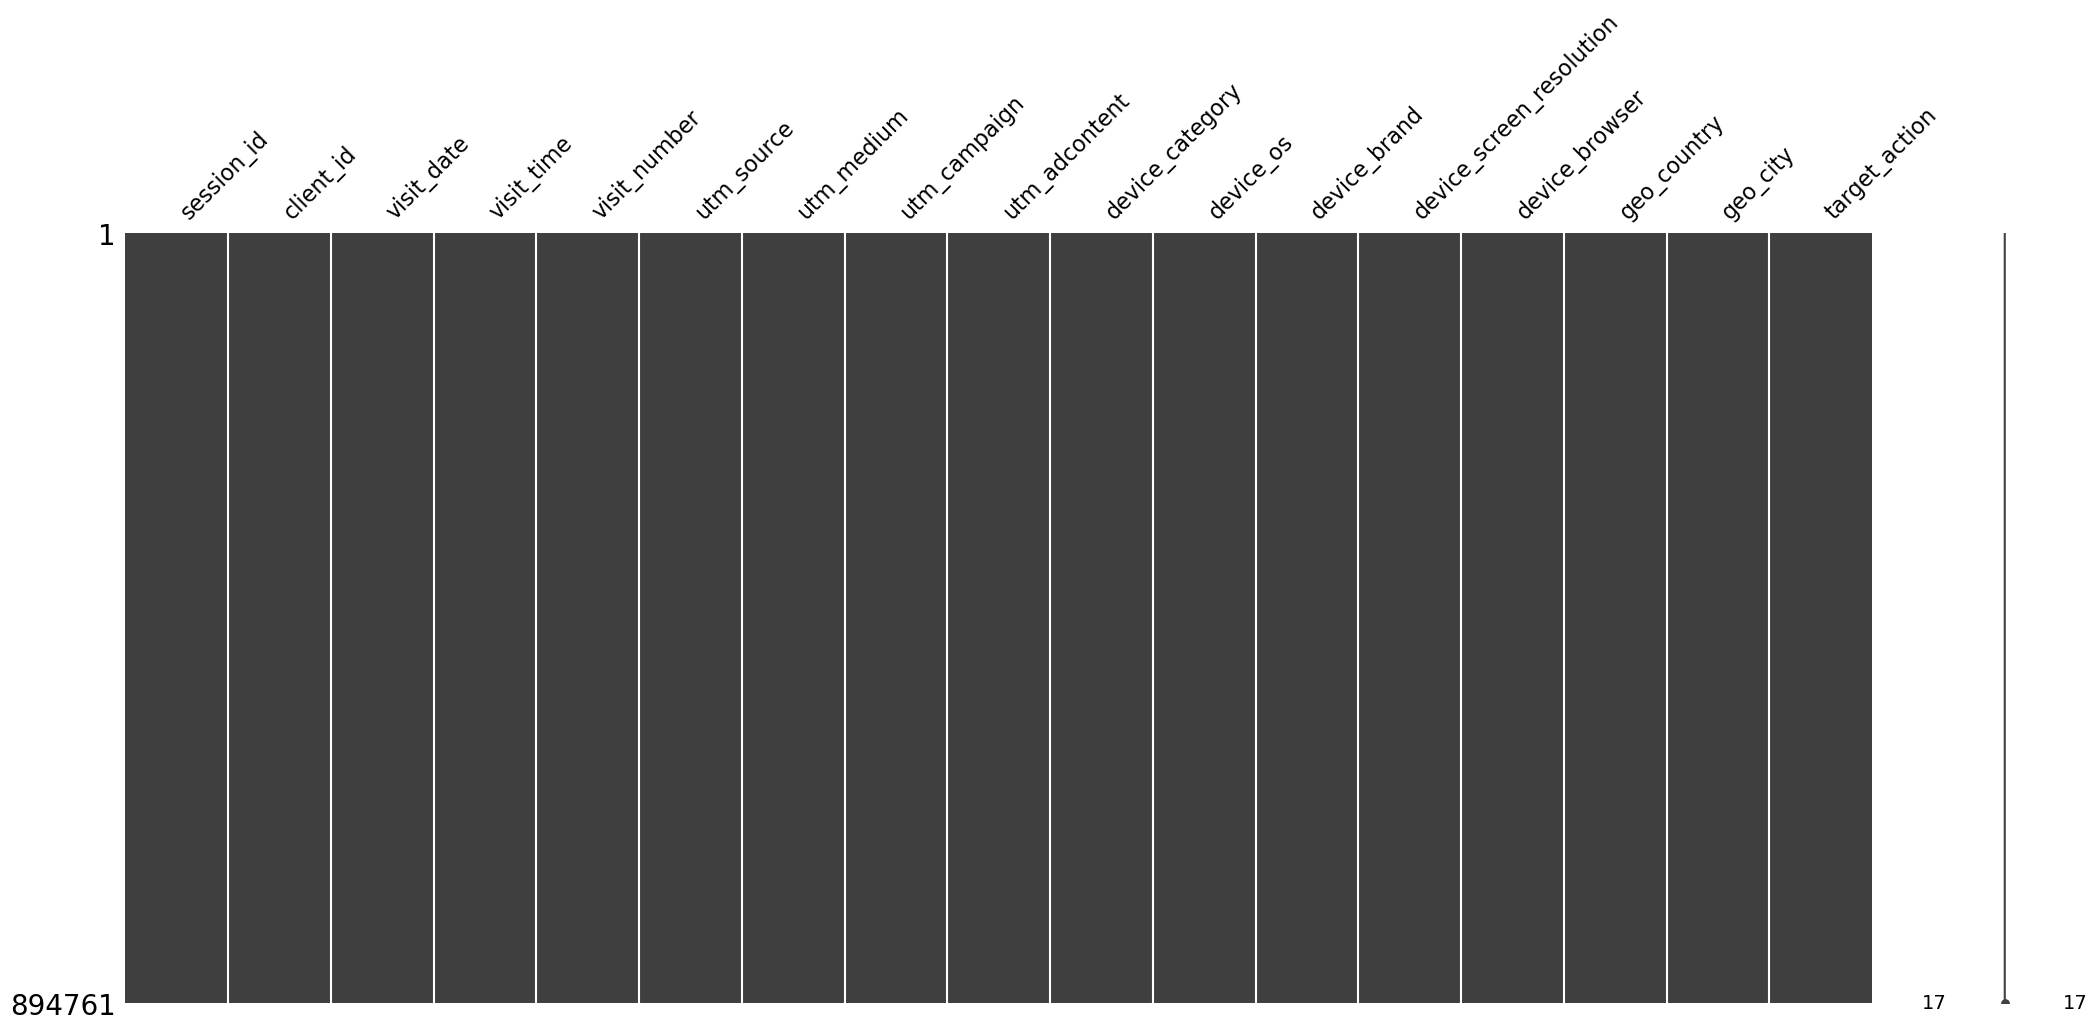

In [212]:
msno.matrix(df_joined);

##### Сохранение промежуточных результатов

In [239]:
with open('data/ga_joined_processed.pkl', 'wb') as file:
    dill.dump(df_joined, file)

##### Исследование распределения utm_source

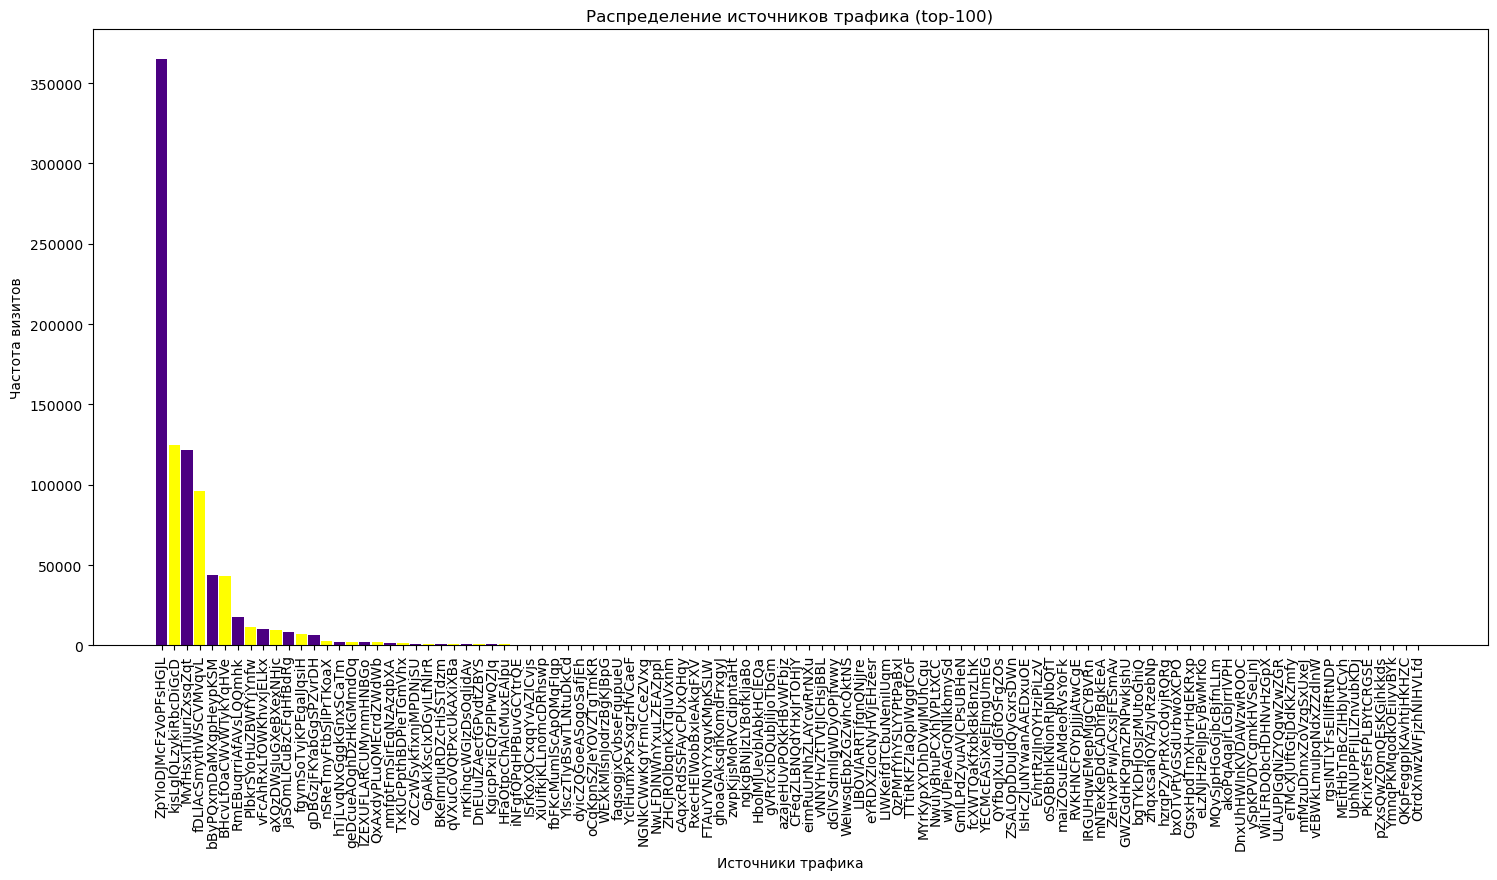

In [240]:
df_sources = df_joined.groupby('utm_source').agg({'utm_source': 'count'})
df_sources = df_sources.rename(columns={'utm_source': 'goes_from'})
df_joined_source = df_sources['goes_from'].sort_values(ascending=False)[0:100]


fig, ax1 = plt.subplots(figsize=(18, 8))

ax1.bar(df_joined_source.index, df_joined_source, width=0.9, color=['indigo', 'yellow'])
plt.xticks(rotation=90)

plt.xlabel('Источники трафика')
plt.ylabel('Частота визитов')
plt.title('Распределение источников трафика (top-100)');

##### Исследование распределения device_brand

In [241]:
df_brands = df_joined.groupby('device_brand').agg({'device_brand': 'count'})
df_brands = df_brands.rename(columns={'device_brand': 'produced_by_brand'})
df_joined_brands = df_brands['produced_by_brand'].sort_values(ascending=False)[0:100]

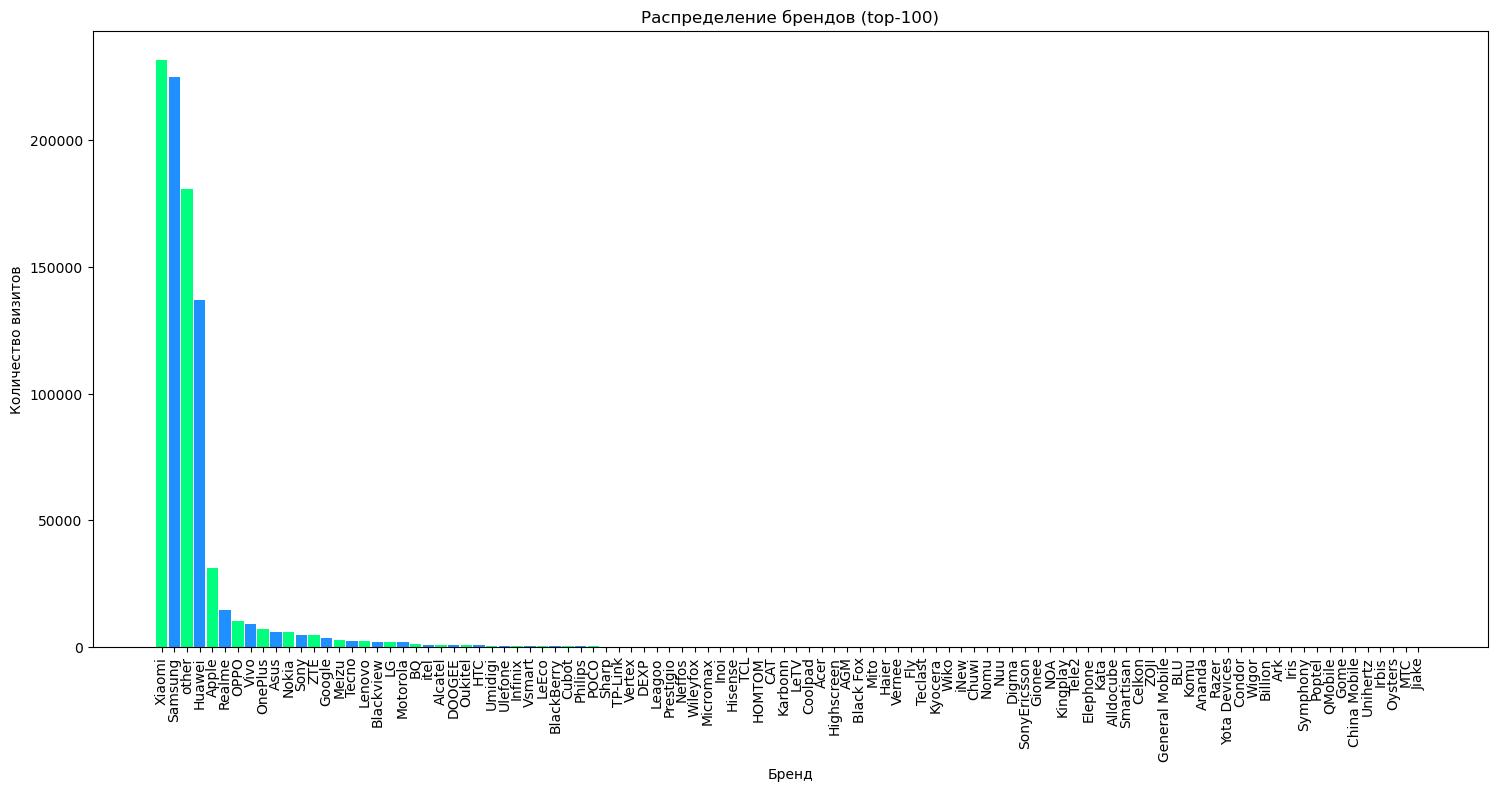

In [242]:
fig, cx = plt.subplots(figsize=(18, 8))

cx.bar(df_joined_brands.index, df_joined_brands, width=0.9, color=['springgreen', 'dodgerblue'])
plt.xticks(rotation=90)

plt.xlabel('Бренд')
plt.ylabel('Количество визитов')
plt.title('Распределение брендов (top-100)');

##### Исследование распределения utm_medium

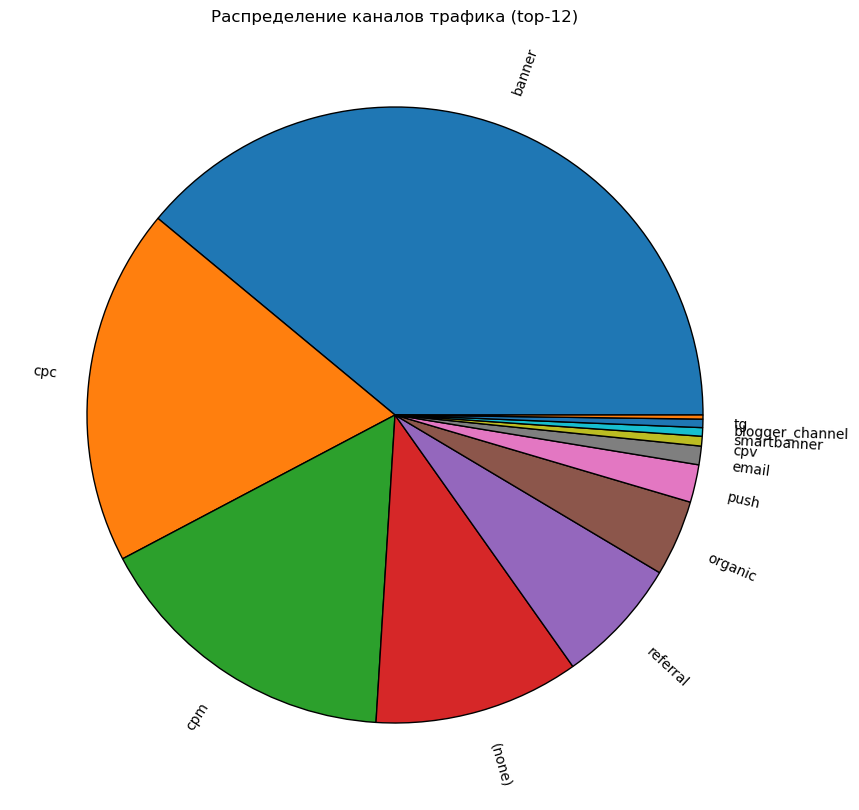

In [243]:
df_medium_stat = df_joined.groupby('utm_medium').agg({'utm_medium': 'count'})
df_medium_stat = df_medium_stat.rename(columns={'utm_medium': 'count_of_medium'})
df_medium_stat = df_medium_stat['count_of_medium'].sort_values(ascending=False)[0:12]

fig, ex = plt.subplots(figsize=(20, 10))

plt.pie(df_medium_stat, labels=df_medium_stat.index, rotatelabels=True, wedgeprops={"edgecolor":"k",'linewidth': 1})
plt.title("Распределение каналов трафика (top-12)")
plt.show();

##### Исследование распределения device_category

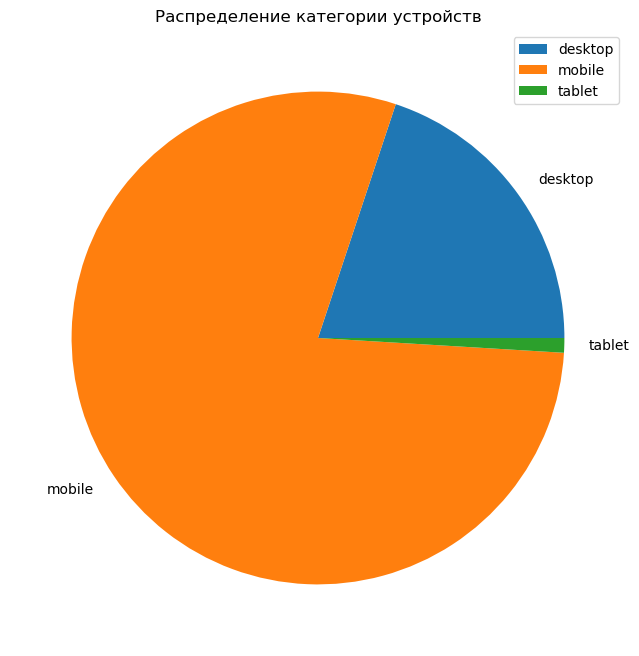

In [244]:
df_categories_stat = df_joined.groupby('device_category').agg({'device_category': 'count'})
df_categories_stat = df_categories_stat.rename(columns={'device_category': 'count_of_category'})

fig, dx = plt.subplots(figsize=(12, 8))

plt.pie(df_categories_stat['count_of_category'], labels=df_categories_stat.index)
plt.title("Распределение категории устройств")
plt.legend()
plt.show();

##### Исследование распределения device_os

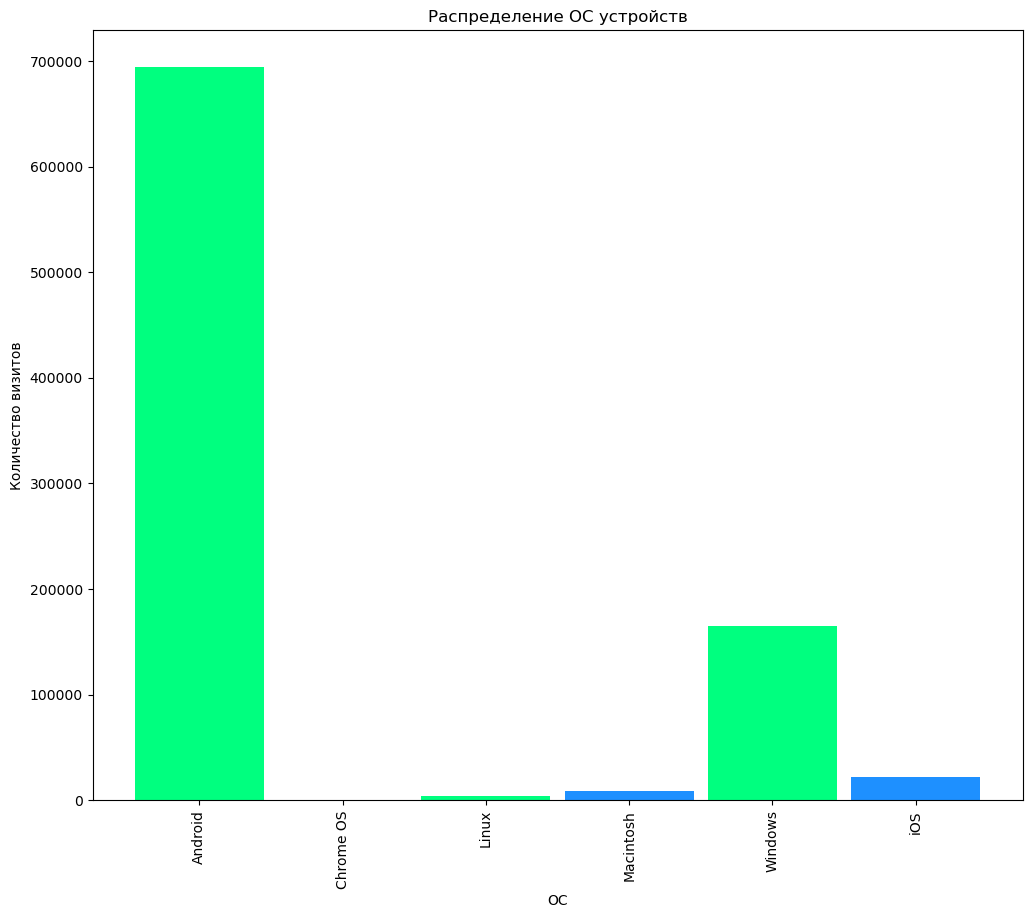

In [245]:
df_os_stat = df_joined.groupby('device_os').agg({'device_os': 'count'})
df_os_stat = df_os_stat.rename(columns={'device_os': 'count_of_os'})

fig, dx = plt.subplots(figsize=(12, 10))

dx.bar(df_os_stat.index, df_os_stat['count_of_os'], width=0.9, color=['springgreen', 'dodgerblue'])
plt.xticks(rotation=90)

plt.xlabel('ОС')
plt.ylabel('Количество визитов')
plt.title("Распределение ОC устройств");

##### Исследование распределения geo_country

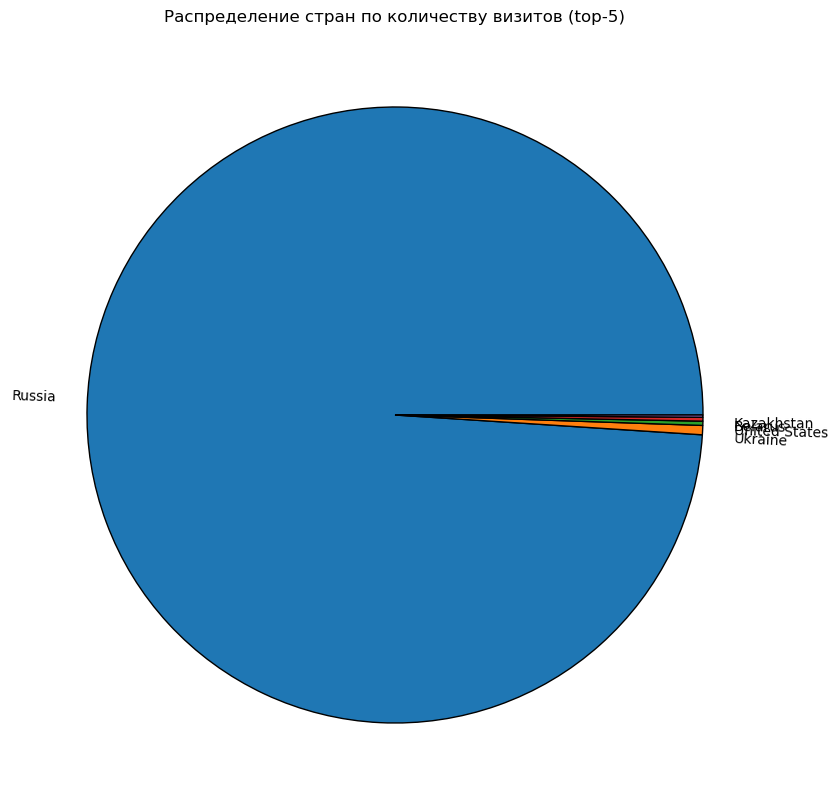

In [246]:
df_country_stat = df_joined.groupby('geo_country').agg({'geo_country': 'count'})
df_country_stat = df_country_stat.rename(columns={'geo_country': 'count_of_visits_countries'})
df_country_stat = df_country_stat['count_of_visits_countries'].sort_values(ascending=False)[0:5]

fig, fx = plt.subplots(figsize=(22, 10))

plt.pie(df_country_stat, labels=df_country_stat.index, rotatelabels=True, wedgeprops={"edgecolor":"k",'linewidth': 1})
plt.title("Распределение стран по количеству визитов (top-5)")
plt.show();

### Feature engineering

In [247]:
with open('data/ga_joined_processed.pkl', 'rb') as file:
    df_joined = dill.load(file)
df_joined.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_action
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0
7,9055461992850812764.1626107740.1626107740,2108389044.1626107740,2021-07-12,19:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Samsung,360x640,Chrome,Russia,Saint Petersburg,0


In [248]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 894576 entries, 0 to 1732265
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   session_id                894576 non-null  object
 1   client_id                 894576 non-null  object
 2   visit_date                894576 non-null  object
 3   visit_time                894576 non-null  object
 4   visit_number              894576 non-null  int64 
 5   utm_source                894576 non-null  object
 6   utm_medium                894576 non-null  object
 7   utm_campaign              894576 non-null  object
 8   utm_adcontent             894576 non-null  object
 9   device_category           894576 non-null  object
 10  device_os                 894576 non-null  object
 11  device_brand              894576 non-null  object
 12  device_screen_resolution  894576 non-null  object
 13  device_browser            894576 non-null  object
 14  geo

#### Исследование связи целевых действий и дат визитов 

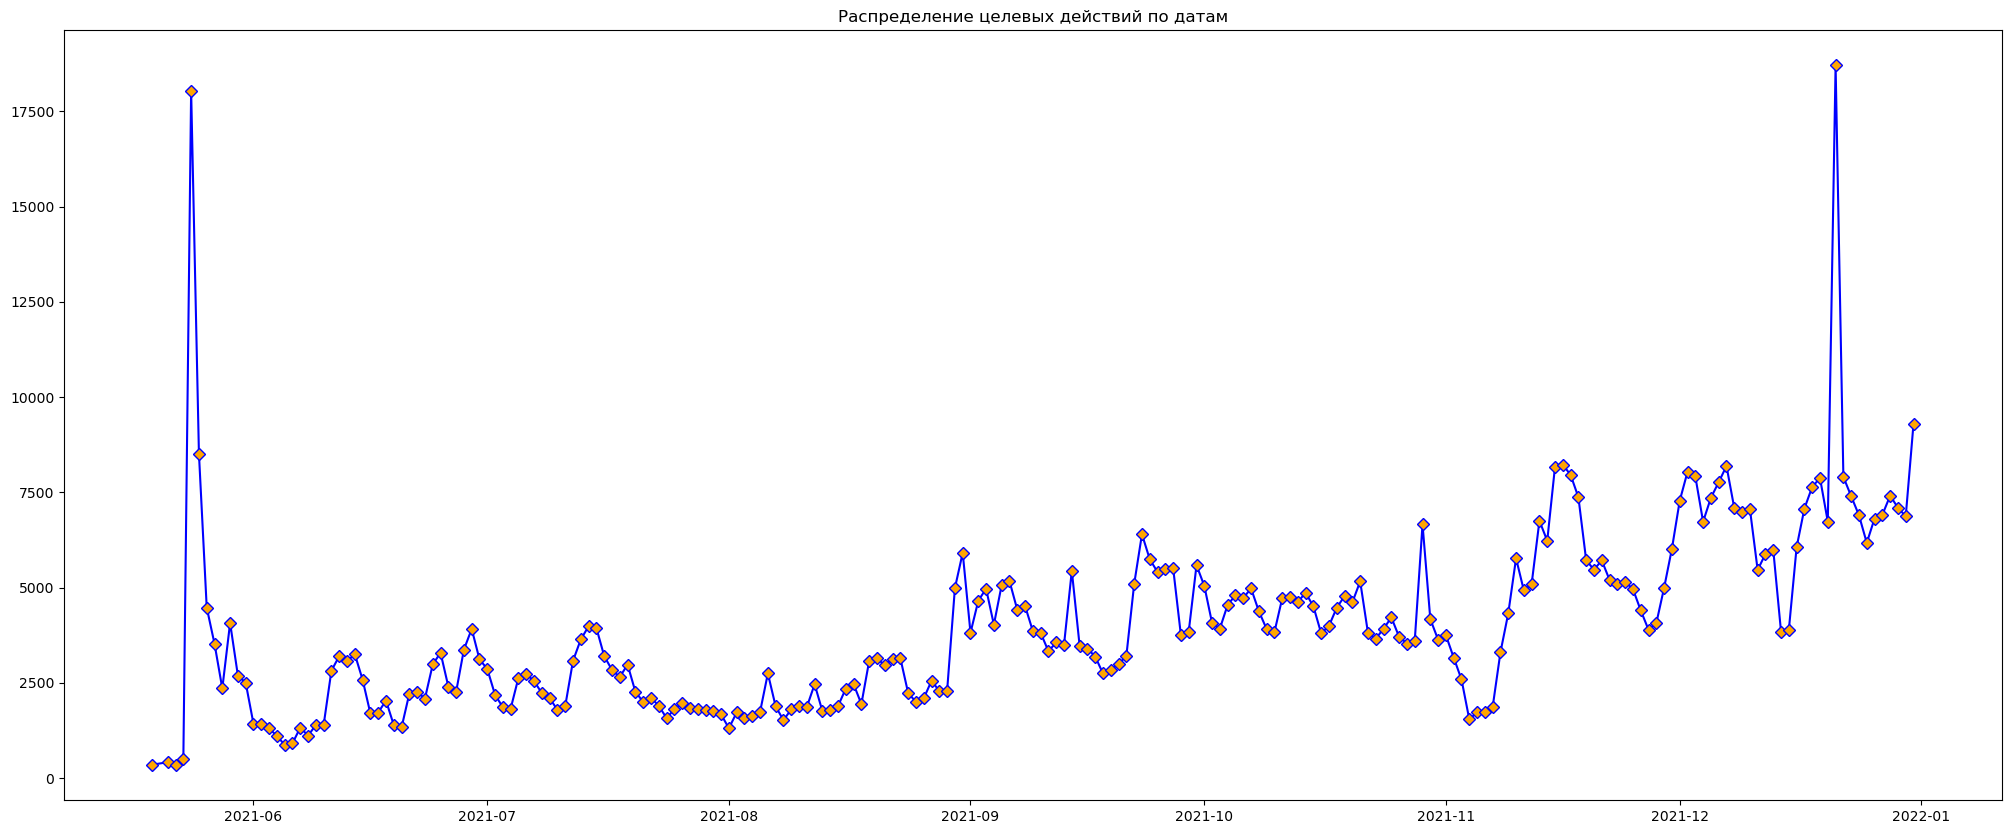

In [249]:
df_visit_stat = df_joined.groupby(['visit_date']).agg({'target_action': 'count'})
df_visit_stat = df_visit_stat.rename(columns={'target_action': 'action_count'})

fig, ex = plt.subplots(figsize=(25, 10))

plt.plot(df_visit_stat.index, df_visit_stat['action_count'], color='blue', marker='D', markerfacecolor='orange')
plt.title("Распределение целевых действий по датам")
plt.show();

#### Обработка категориальных переменных

In [250]:
columns_df = df_joined.select_dtypes(['object']).drop(columns=['session_id', 'client_id']).columns
for col in columns_df:
    print(f"Уникальных значений в столбце {col}: {len(df_joined[col].unique())}")

Уникальных значений в столбце visit_date: 226
Уникальных значений в столбце visit_time: 82161
Уникальных значений в столбце utm_source: 224
Уникальных значений в столбце utm_medium: 47
Уникальных значений в столбце utm_campaign: 227
Уникальных значений в столбце utm_adcontent: 249
Уникальных значений в столбце device_category: 3
Уникальных значений в столбце device_os: 6
Уникальных значений в столбце device_brand: 180
Уникальных значений в столбце device_screen_resolution: 3764
Уникальных значений в столбце device_browser: 1
Уникальных значений в столбце geo_country: 128
Уникальных значений в столбце geo_city: 1693


Для использования OneHotEncoder в некоторых столбцах слишком много значений. Исправим это

***device_screen_resolution*** напрямую связана с ***device_category***, к тому же, в колонке перемешаны логические и физические разрешения, что мешает их градации. 
Удаляем колонку

In [251]:
df_joined = df_joined.drop(columns=['device_screen_resolution'])
df_joined

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,geo_city,target_action
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Zlatoust,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0
7,9055461992850812764.1626107740.1626107740,2108389044.1626107740,2021-07-12,19:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Samsung,Chrome,Russia,Saint Petersburg,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732258,9055394342833425189.1638599463.1638599463,2108373293.1638599461,2021-12-04,09:31:03,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Samsung,Chrome,Russia,Birsk,0
1732260,9055398929844789828.1624891784.1624891784,2108374361.1624891972,2021-06-28,17:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,vXsFkagGabkcWKlgLzSg,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Samsung,Chrome,Russia,Naro-Fominsk,0
1732261,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,desktop,Windows,other,Chrome,Russia,Moscow,0
1732264,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,Chrome,Russia,Chelyabinsk,0


Колонки ***visit_*** по условию задачи не нужны, значений в них много, но они всё же могут оказать влияние (например, данные ***utm_campaign*** хэшированы и их нельзя в текущей ситуации интерпретировать), поэтому время заменяем на время суток, а дату разбиваем на год, месяц и день

In [252]:
df_joined['visit_daytime'] = df_joined['visit_time'].apply(lambda x: 'night' if x >= datetime.time(22, 0) or x <= datetime.time(4, 59, 59) else ('morning' if x >= datetime.time(5, 0, 0) and x < datetime.time(11, 59, 59) else ('afternoon' if x < datetime.time(16, 59, 59) else 'evening')))

In [253]:
df_joined['visit_year'] = pd.DatetimeIndex(df_joined['visit_date']).year
df_joined['visit_month'] = pd.DatetimeIndex(df_joined['visit_date']).month
df_joined['visit_day'] = pd.DatetimeIndex(df_joined['visit_date']).day
df_joined.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,geo_city,target_action,visit_daytime,visit_year,visit_month,visit_day
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Zlatoust,0,afternoon,2021,11,24
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,0,night,2021,12,28
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0,morning,2021,5,29
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0,morning,2021,5,29
7,9055461992850812764.1626107740.1626107740,2108389044.1626107740,2021-07-12,19:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Samsung,Chrome,Russia,Saint Petersburg,0,evening,2021,7,12


In [254]:
df_joined = df_joined.drop(columns=['visit_date', 'visit_time'])

Импользуем модуль ***geopy***, чтобы превратить страну и город в числовые значения, но, к сожалению, не все координаты будут обнаружены, поэтому от записей с пропусками придётся отказаться

Сперва создаём фичу ***geo_adress***, в которой соединим ***geo_country*** и ***geo_city*** 

In [255]:
df_joined['geo_adress'] = df_joined.apply(lambda x: x['geo_country'] + ',' + x['geo_city'], axis=1)
df_joined.head()

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,geo_city,target_action,visit_daytime,visit_year,visit_month,visit_day,geo_adress
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Zlatoust,0,afternoon,2021,11,24,"Russia,Zlatoust"
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,0,night,2021,12,28,"Russia,Krasnoyarsk"
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0,morning,2021,5,29,"Russia,Moscow"
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0,morning,2021,5,29,"Russia,Moscow"
7,9055461992850812764.1626107740.1626107740,2108389044.1626107740,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Samsung,Chrome,Russia,Saint Petersburg,0,evening,2021,7,12,"Russia,Saint Petersburg"


Чтобы не делать повторных запросов к сервису geopy, сперва создадим список использованных в датасете адресов, а затем преобразуем его в словарь с координатами в качестве значений

In [258]:
adresses = list(df_joined['geo_adress'].unique())
locations = list()
geopy.geocoders.options.default_timeout = 7
geopy.geocoders.options.default_user_agent = 'analysis_auto'
geolocator = Nominatim(user_agent = 'analysis_auto')

for adress in adresses:
    locations.append(get_location(adress=adress, geolocator=geolocator))

locations_dict = dict(zip(adresses, locations))
# locations_dict = dict(zip(adresses, list(map(get_location, adresses)))) # из-за особенностей библиотеки geopy этот вариант выпадает с ошибкой. Пробуем цикл

Запишем результат, чтобы ещё три часа не ждать вычислений

In [259]:
with open('data/ga_locations_dict.pkl', 'wb') as file:
    dill.dump(locations_dict, file)

In [260]:
locations_dict = 0
with open('data/ga_locations_dict.pkl', 'rb') as file:
    locations_dict = dill.load(file)

In [261]:
df_joined['geo_long'] = df_joined['geo_adress'].apply(lambda x: locations_dict[x] if locations_dict[x] is None else locations_dict[x].longitude)
df_joined['geo_lat'] = df_joined['geo_adress'].apply(lambda x: locations_dict[x] if locations_dict[x] is None else locations_dict[x].latitude)

In [262]:
print_missing_values(df_joined[['geo_long', 'geo_lat']])

Процент пропущенных значений:
geo_long    0.21295
geo_lat     0.21295
dtype: float64


Небольшой процент пропущенных значений удаляется безболезненно

In [263]:
df_joined = df_joined[~(df_joined['geo_lat'].isna() & df_joined['geo_long'].isna())]

In [264]:
df_joined = df_joined.drop(columns=['geo_adress', 'geo_city', 'geo_country'])
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892671 entries, 0 to 1732265
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   session_id       892671 non-null  object 
 1   client_id        892671 non-null  object 
 2   visit_number     892671 non-null  int64  
 3   utm_source       892671 non-null  object 
 4   utm_medium       892671 non-null  object 
 5   utm_campaign     892671 non-null  object 
 6   utm_adcontent    892671 non-null  object 
 7   device_category  892671 non-null  object 
 8   device_os        892671 non-null  object 
 9   device_brand     892671 non-null  object 
 10  device_browser   892671 non-null  object 
 11  target_action    892671 non-null  int64  
 12  visit_daytime    892671 non-null  object 
 13  visit_year       892671 non-null  int64  
 14  visit_month      892671 non-null  int64  
 15  visit_day        892671 non-null  int64  
 16  geo_long         892671 non-null  flo

In [265]:
columns_df = df_joined.select_dtypes(['object']).drop(columns=['session_id', 'client_id']).columns
for col in columns_df:
    print(f"Уникальных значений в столбце {col}: {len(df_joined[col].unique())}")

Уникальных значений в столбце utm_source: 224
Уникальных значений в столбце utm_medium: 47
Уникальных значений в столбце utm_campaign: 227
Уникальных значений в столбце utm_adcontent: 249
Уникальных значений в столбце device_category: 3
Уникальных значений в столбце device_os: 6
Уникальных значений в столбце device_brand: 180
Уникальных значений в столбце device_browser: 1
Уникальных значений в столбце visit_daytime: 4


Ограничим число значений в остальных категориях по топ-100 визитов, т. е., если по источнику, кампании и т. д. приходило запросов меньше 100, ставим ему значение other. Мы можем это проделать, поскольку графики показывают, что в этот топ войдут самые массовые значения категорий

In [266]:
cols_to_top = ['utm_source', 'utm_campaign', 'utm_adcontent']

In [267]:
df_joined = trim_values_top(df_joined, cols_to_top, 50)

Число уникальных значений в новой колонке utm_source_short : 58
Число уникальных значений в новой колонке utm_campaign_short : 109
Число уникальных значений в новой колонке utm_adcontent_short : 79


In [268]:
df_joined = df_joined.drop(columns=cols_to_top)

In [269]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892671 entries, 0 to 1732265
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   session_id           892671 non-null  object 
 1   client_id            892671 non-null  object 
 2   visit_number         892671 non-null  int64  
 3   utm_medium           892671 non-null  object 
 4   device_category      892671 non-null  object 
 5   device_os            892671 non-null  object 
 6   device_brand         892671 non-null  object 
 7   device_browser       892671 non-null  object 
 8   target_action        892671 non-null  int64  
 9   visit_daytime        892671 non-null  object 
 10  visit_year           892671 non-null  int64  
 11  visit_month          892671 non-null  int64  
 12  visit_day            892671 non-null  int64  
 13  geo_long             892671 non-null  float64
 14  geo_lat              892671 non-null  float64
 15  utm_source_short

In [270]:
df_joined.head()

,session_id,client_id,visit_number,utm_medium,device_category,device_os,device_brand,device_browser,target_action,visit_daytime,visit_year,visit_month,visit_day,geo_long,geo_lat,utm_source_short,utm_campaign_short,utm_adcontent_short
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,banner,mobile,Android,Huawei,Chrome,0,afternoon,2021,11,24,59.529269,55.034639,ZpYIoDJMcFzVoPFsHGJL,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,banner,mobile,Android,Huawei,Chrome,0,night,2021,12,28,92.872515,56.009097,ZpYIoDJMcFzVoPFsHGJL,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,cpc,mobile,Android,Xiaomi,Chrome,0,morning,2021,5,29,37.606392,55.625578,kjsLglQLzykiRbcDiGcD,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,cpc,mobile,Android,Xiaomi,Chrome,0,morning,2021,5,29,37.606392,55.625578,kjsLglQLzykiRbcDiGcD,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp
7,9055461992850812764.1626107740.1626107740,2108389044.1626107740,1,banner,mobile,Android,Samsung,Chrome,0,evening,2021,7,12,30.158655,59.960674,ZpYIoDJMcFzVoPFsHGJL,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf


Запишем данные в файл, чтобы сохранить текущие результаты

In [271]:
with open('data/ga_joined_fe.pkl', 'wb') as file:
    dill.dump(df_joined, file)

In [272]:
df_joined = 0
with open('data/ga_joined_fe.pkl', 'rb') as file:
    df_joined = dill.load(file)
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892671 entries, 0 to 1732265
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   session_id           892671 non-null  object 
 1   client_id            892671 non-null  object 
 2   visit_number         892671 non-null  int64  
 3   utm_medium           892671 non-null  object 
 4   device_category      892671 non-null  object 
 5   device_os            892671 non-null  object 
 6   device_brand         892671 non-null  object 
 7   device_browser       892671 non-null  object 
 8   target_action        892671 non-null  int64  
 9   visit_daytime        892671 non-null  object 
 10  visit_year           892671 non-null  int64  
 11  visit_month          892671 non-null  int64  
 12  visit_day            892671 non-null  int64  
 13  geo_long             892671 non-null  float64
 14  geo_lat              892671 non-null  float64
 15  utm_source_short

In [273]:
data_ohe = df_joined.select_dtypes(['object']).drop(columns=['session_id', 'client_id'])
data_ohe

,utm_medium,device_category,device_os,device_brand,device_browser,visit_daytime,utm_source_short,utm_campaign_short,utm_adcontent_short
0,banner,mobile,Android,Huawei,Chrome,afternoon,ZpYIoDJMcFzVoPFsHGJL,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp
2,banner,mobile,Android,Huawei,Chrome,night,ZpYIoDJMcFzVoPFsHGJL,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp
3,cpc,mobile,Android,Xiaomi,Chrome,morning,kjsLglQLzykiRbcDiGcD,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM
4,cpc,mobile,Android,Xiaomi,Chrome,morning,kjsLglQLzykiRbcDiGcD,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp
7,banner,mobile,Android,Samsung,Chrome,evening,ZpYIoDJMcFzVoPFsHGJL,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf
...,...,...,...,...,...,...,...,...,...
1732258,banner,mobile,Android,Samsung,Chrome,morning,ZpYIoDJMcFzVoPFsHGJL,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp
1732260,cpc,mobile,Android,Samsung,Chrome,evening,kjsLglQLzykiRbcDiGcD,vXsFkagGabkcWKlgLzSg,vCIpmpaGBnIQhyYNkXqp
1732261,cpc,desktop,Windows,other,Chrome,morning,BHcvLfOaCWvWTykYqHVe,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp
1732264,banner,mobile,Android,Xiaomi,Chrome,afternoon,ZpYIoDJMcFzVoPFsHGJL,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf


In [274]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(data_ohe)

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [275]:
matrix_trans = ohe.transform(data_ohe)

In [276]:
df_joined[ohe.get_feature_names_out()] = matrix_trans
df_joined = df_joined.drop(columns=list(data_ohe.columns))

C:\Users\Fiore\AppData\Local\Temp\ipykernel_14316\2044804806.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_joined[ohe.get_feature_names_out()] = matrix_trans
C:\Users\Fiore\AppData\Local\Temp\ipykernel_14316\2044804806.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_joined[ohe.get_feature_names_out()] = matrix_trans
C:\Users\Fiore\AppData\Local\Temp\ipykernel_14316\2044804806.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

In [277]:
df_joined.head()

,session_id,client_id,visit_number,target_action,visit_year,visit_month,visit_day,geo_long,geo_lat,utm_medium_(none),...,utm_adcontent_short_vIKILzdGQEEbEpgPefxF,utm_adcontent_short_vVNkKrQAgRGFuwKyFazn,utm_adcontent_short_vilbbyUvEWbiJvxXpaNN,utm_adcontent_short_wyGnhqrmQWmiuxOXwecV,utm_adcontent_short_xZYEHLyYdGXkJENJpTtu,utm_adcontent_short_xhoenQgDQsgfEPYNPwKO,utm_adcontent_short_xnyHaukLtAvgViiZSyBC,utm_adcontent_short_yEzOkUNmavmsRTXaISLf,utm_adcontent_short_yYdBRbPmBMUZHXwqGxNx,utm_adcontent_short_zEHnFIjqNyjvDvXKeMqx
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,0,2021,11,24,59.529269,55.034639,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,0,2021,12,28,92.872515,56.009097,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,0,2021,5,29,37.606392,55.625578,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,0,2021,5,29,37.606392,55.625578,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,9055461992850812764.1626107740.1626107740,2108389044.1626107740,1,0,2021,7,12,30.158655,59.960674,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [278]:
df_joined.to_csv('data/ga_ohetransformed_fe.csv', index=False, encoding='utf-8')

#### Обработка числовых переменных

In [279]:
df_joined = pd.read_csv("data/ga_ohetransformed_fe.csv", dtype={'session_id': str, 'client_id': str})

In [280]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892671 entries, 0 to 892670
Columns: 496 entries, session_id to utm_adcontent_short_zEHnFIjqNyjvDvXKeMqx
dtypes: float64(489), int64(5), object(2)
memory usage: 3.3+ GB


In [283]:
data_std = df_joined[['visit_year', 'visit_month', 'visit_day', 'geo_long', 'geo_lat', 'visit_number']]
data_std.head()

,visit_year,visit_month,visit_day,geo_long,geo_lat,visit_number
0,2021,11,24,59.529269,55.034639,1
1,2021,12,28,92.872515,56.009097,1
2,2021,5,29,37.606392,55.625578,1
3,2021,5,29,37.606392,55.625578,2
4,2021,7,12,30.158655,59.960674,1


In [284]:
std_scaler = StandardScaler()
std_scaler.fit(data_std)

StandardScaler()

In [285]:
matrix_std = std_scaler.transform(data_std)
quant_values = list(data_std.columns)

for i in range(len(quant_values)):
    quant_values[i] += '_std'

In [286]:
df_joined[quant_values] = matrix_std
df_joined.head()

,session_id,client_id,visit_number,target_action,visit_year,visit_month,visit_day,geo_long,geo_lat,utm_medium_(none),...,utm_adcontent_short_xnyHaukLtAvgViiZSyBC,utm_adcontent_short_yEzOkUNmavmsRTXaISLf,utm_adcontent_short_yYdBRbPmBMUZHXwqGxNx,utm_adcontent_short_zEHnFIjqNyjvDvXKeMqx,visit_year_std,visit_month_std,visit_day_std,geo_long_std,geo_lat_std,visit_number_std
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,0,2021,11,24,59.529269,55.034639,0.0,...,0.0,0.0,0.0,0.0,0.0,0.665896,0.801978,0.832969,-0.066978,-0.139779
1,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,0,2021,12,28,92.872515,56.009097,0.0,...,0.0,0.0,0.0,0.0,0.0,1.128857,1.257863,2.511989,0.161169,-0.139779
2,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,0,2021,5,29,37.606392,55.625578,0.0,...,0.0,0.0,0.0,0.0,0.0,-2.111872,1.371834,-0.270970,0.071377,-0.139779
3,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,0,2021,5,29,37.606392,55.625578,0.0,...,0.0,0.0,0.0,0.0,0.0,-2.111872,1.371834,-0.270970,0.071377,-0.068497
4,9055461992850812764.1626107740.1626107740,2108389044.1626107740,1,0,2021,7,12,30.158655,59.960674,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.185949,-0.565676,-0.646006,1.086340,-0.139779


Чтобы подтвердить, что масштабирование сохранило соотношение переменных, строим график

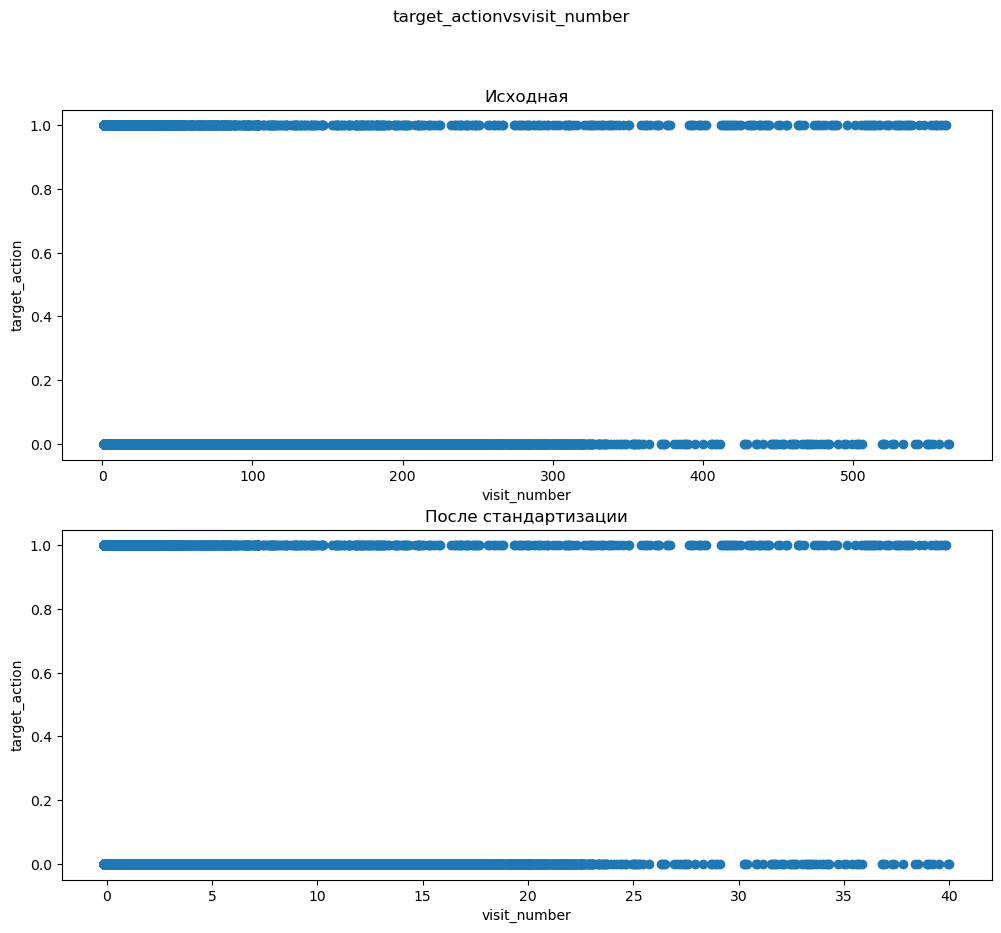

In [287]:
draw_figure_check_std(df_joined, 'visit_number', 'target_action')

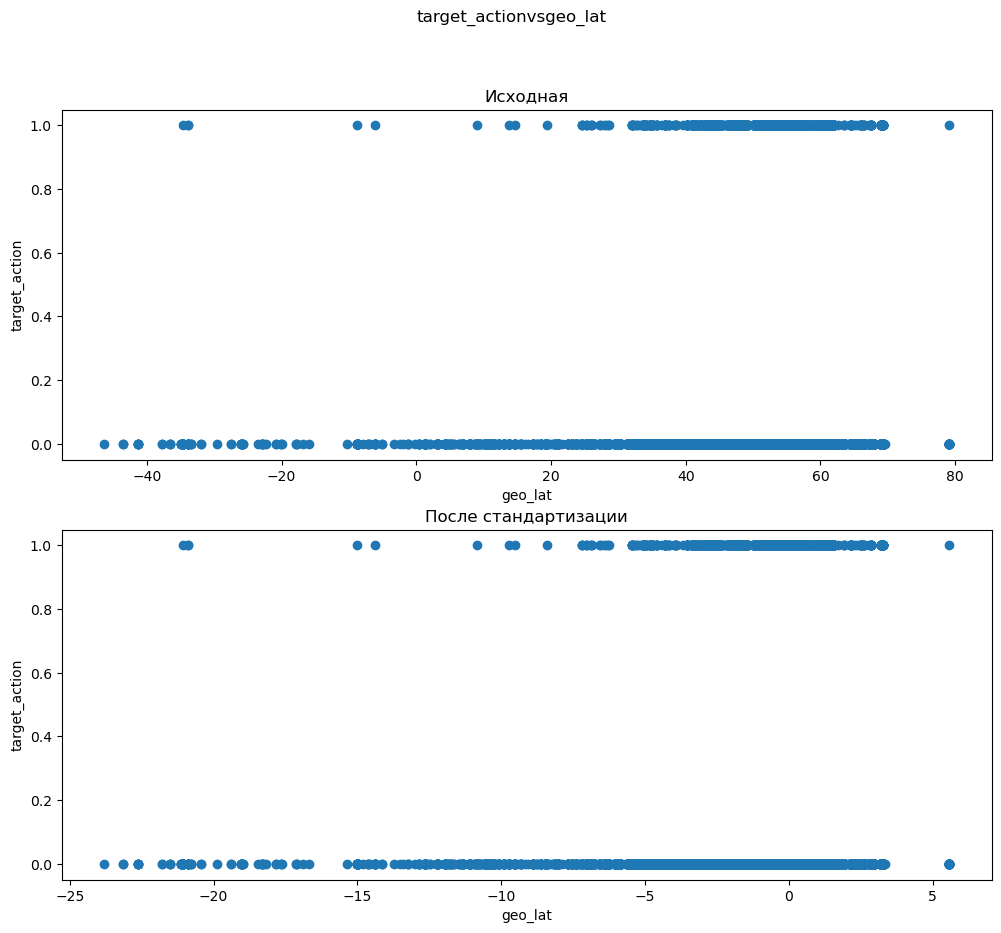

In [288]:
draw_figure_check_std(df_joined, 'geo_lat', 'target_action')

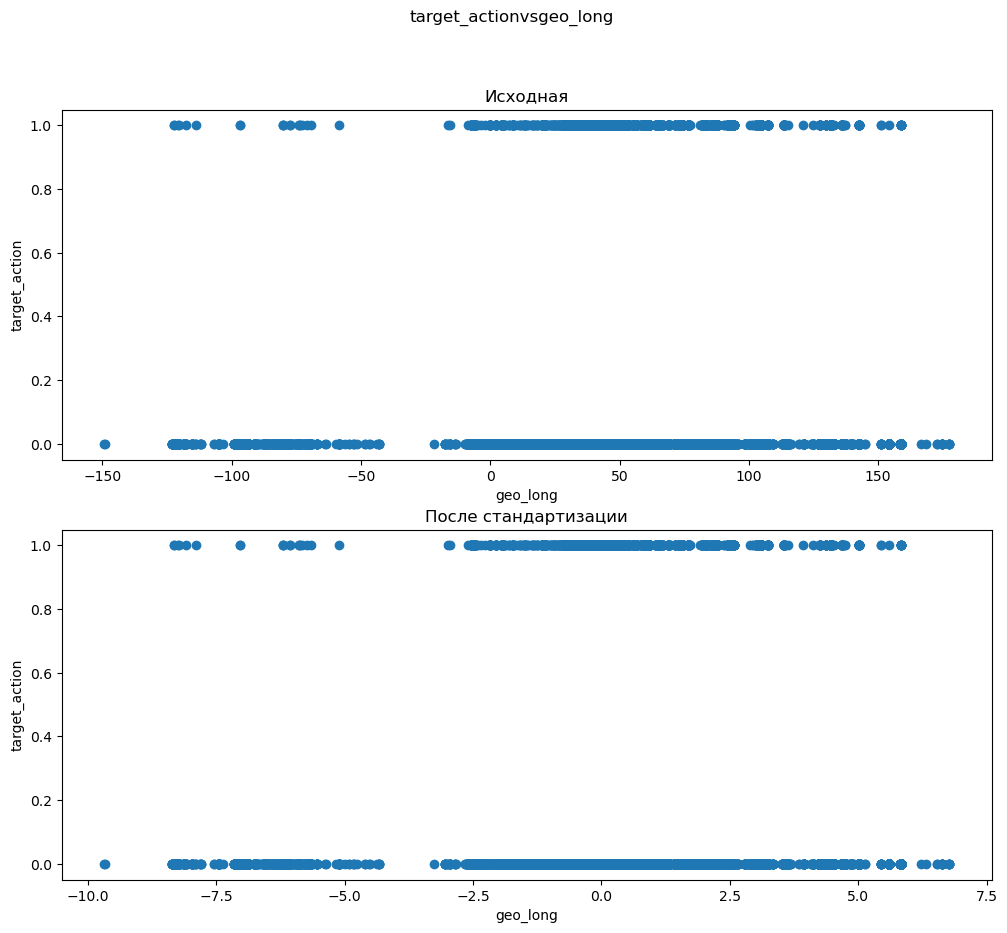

In [289]:
draw_figure_check_std(df_joined, 'geo_long', 'target_action')

In [290]:
df_joined = df_joined.drop(columns=list(data_std.columns))

In [291]:
df_joined.head()

,session_id,client_id,target_action,utm_medium_(none),utm_medium_(not set),utm_medium_app,utm_medium_article,utm_medium_banner,utm_medium_blogger_channel,utm_medium_blogger_header,...,utm_adcontent_short_xnyHaukLtAvgViiZSyBC,utm_adcontent_short_yEzOkUNmavmsRTXaISLf,utm_adcontent_short_yYdBRbPmBMUZHXwqGxNx,utm_adcontent_short_zEHnFIjqNyjvDvXKeMqx,visit_year_std,visit_month_std,visit_day_std,geo_long_std,geo_lat_std,visit_number_std
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.665896,0.801978,0.832969,-0.066978,-0.139779
1,9055446045651783499.1640648526.1640648526,2108385331.1640648523,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.128857,1.257863,2.511989,0.161169,-0.139779
2,9055447046360770272.1622255328.1622255328,2108385564.1622255328,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-2.111872,1.371834,-0.270970,0.071377,-0.139779
3,9055447046360770272.1622255345.1622255345,2108385564.1622255328,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-2.111872,1.371834,-0.270970,0.071377,-0.068497
4,9055461992850812764.1626107740.1626107740,2108389044.1626107740,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.185949,-0.565676,-0.646006,1.086340,-0.139779


Записываем получившийся датасет

In [292]:
df_joined.to_csv('data/ga_for_modeling.csv', index=False, encoding='utf-8')

### Modeling

#### Поиск корреляций

In [16]:
df_to_modeling = pd.read_csv("data/ga_for_modeling.csv", dtype={'session_id': str, 'client_id': str})

df_to_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892671 entries, 0 to 892670
Columns: 496 entries, session_id to visit_number_std
dtypes: float64(493), int64(1), object(2)
memory usage: 3.3+ GB


Сделаем матрицу корреляций

In [17]:
data_corr = df_to_modeling.drop(columns=['session_id', 'client_id']).corr()

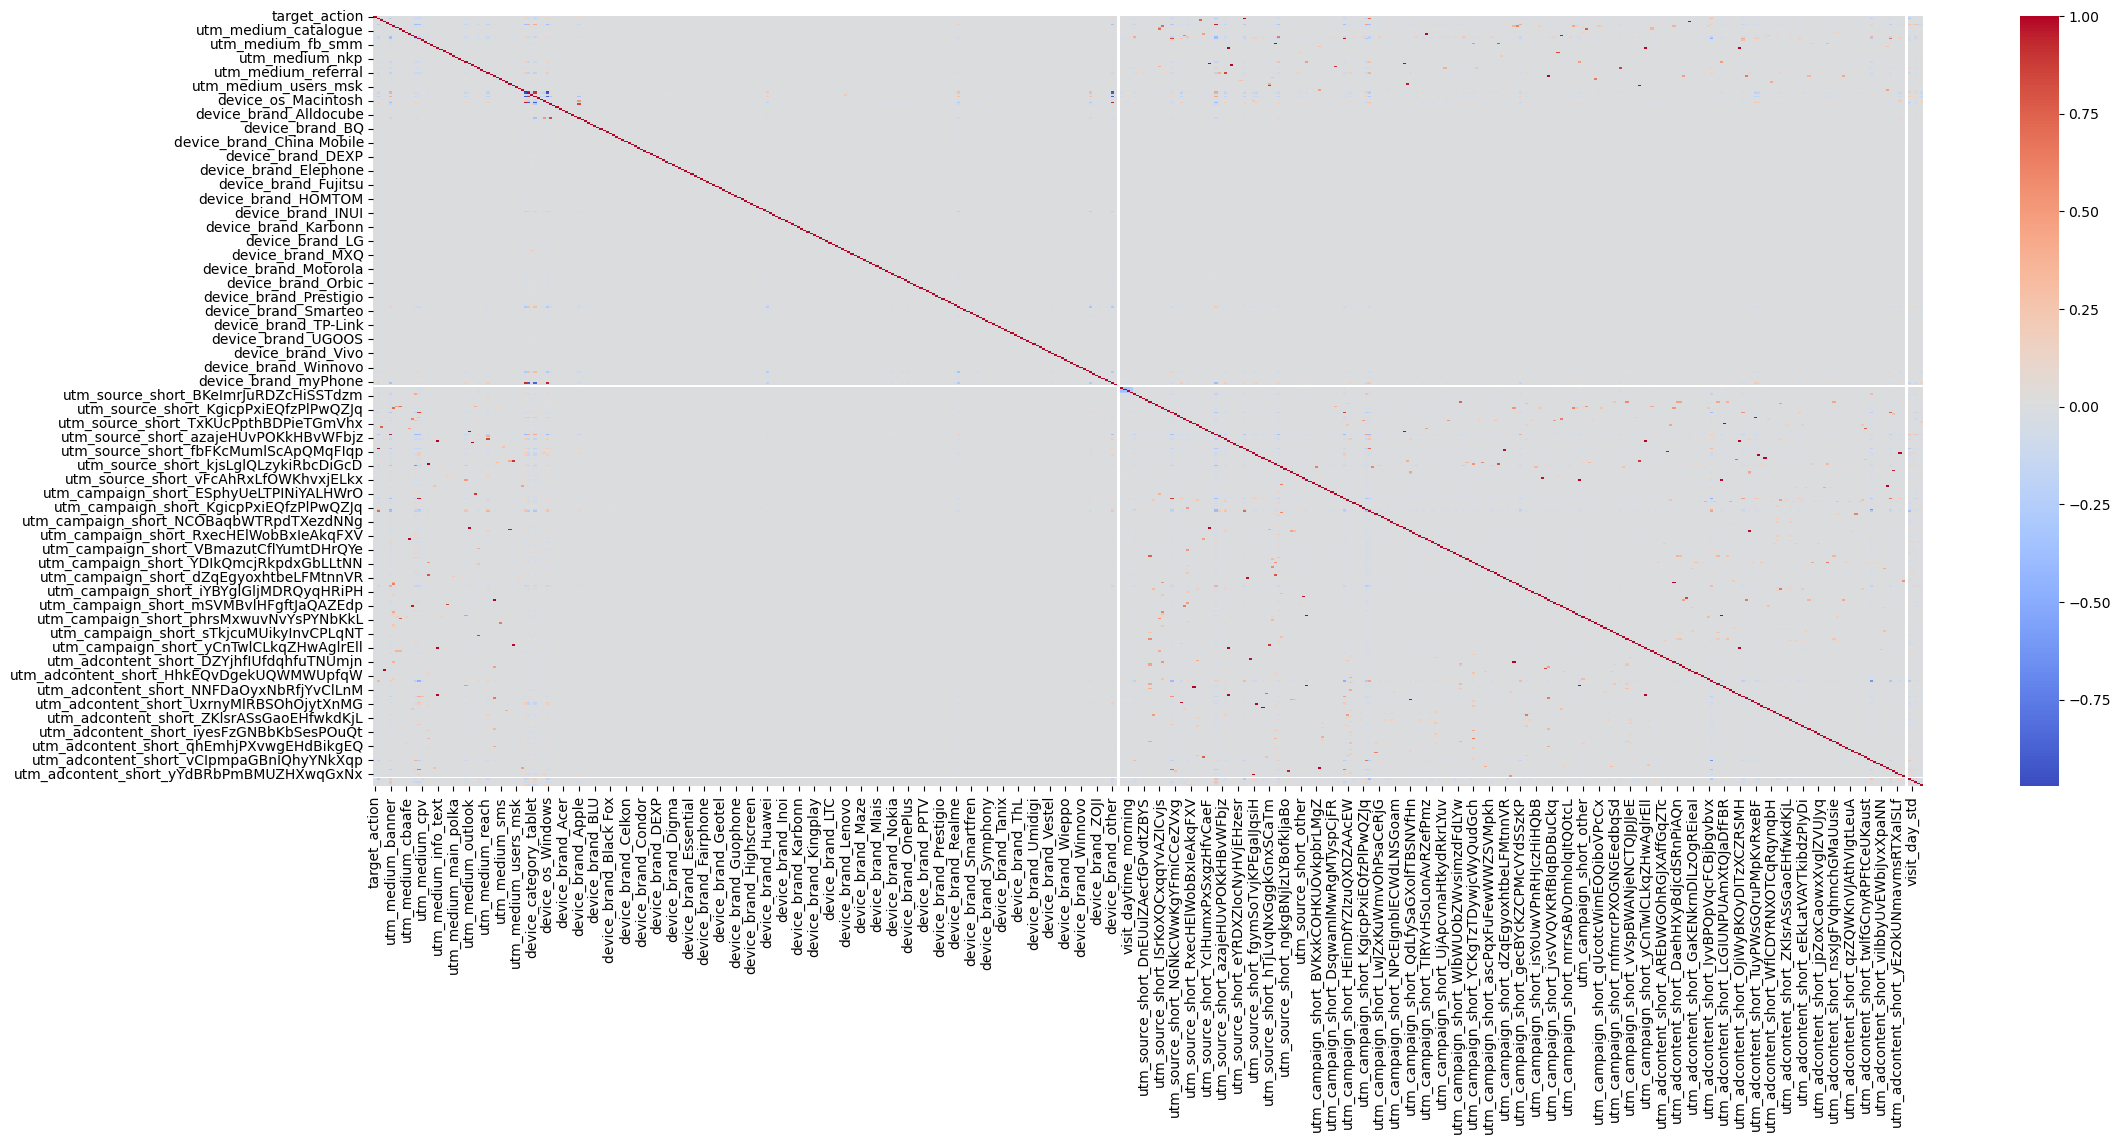

In [18]:
plt.figure(figsize = (25, 10))
sns.heatmap(data_corr, cmap="coolwarm");

Очень много переменных практически не коррелируют между собой

In [21]:
data_corr.head()

,target_action,utm_medium_(none),utm_medium_(not set),utm_medium_app,utm_medium_article,utm_medium_banner,utm_medium_blogger_channel,utm_medium_blogger_header,utm_medium_blogger_stories,utm_medium_catalogue,...,utm_adcontent_short_xnyHaukLtAvgViiZSyBC,utm_adcontent_short_yEzOkUNmavmsRTXaISLf,utm_adcontent_short_yYdBRbPmBMUZHXwqGxNx,utm_adcontent_short_zEHnFIjqNyjvDvXKeMqx,visit_year_std,visit_month_std,visit_day_std,geo_long_std,geo_lat_std,visit_number_std
target_action,1.000000,0.027270,0.003250,-0.002781,-0.000184,0.001769,-0.000776,-0.001821,-0.002704,-0.000260,...,-0.007511,-0.001696,-0.015540,-0.001057,NaN,-0.055688,-0.003458,-0.005163,-0.006187,0.044031
utm_medium_(none),0.027270,1.000000,-0.003635,-0.007886,-0.000367,-0.276195,-0.023020,-0.003635,-0.005397,-0.000519,...,-0.015865,-0.003385,-0.031608,-0.004267,NaN,-0.290300,0.063069,-0.052225,-0.018115,-0.017039
utm_medium_(not set),0.003250,-0.003635,1.000000,-0.000238,-0.000011,-0.008342,-0.000695,-0.000110,-0.000163,-0.000016,...,-0.000479,-0.000102,-0.000955,-0.000129,NaN,-0.000497,-0.004063,-0.001545,0.001455,0.003550
utm_medium_app,-0.002781,-0.007886,-0.000238,1.000000,-0.000024,-0.018097,-0.001508,-0.000238,-0.000354,-0.000034,...,-0.001040,-0.000222,-0.002071,-0.000280,NaN,0.015388,-0.020276,-0.008124,0.005339,-0.001381
utm_medium_article,-0.000184,-0.000367,-0.000011,-0.000024,1.000000,-0.000843,-0.000070,-0.000011,-0.000016,-0.000002,...,-0.000048,-0.000010,-0.000096,-0.000013,NaN,0.000705,-0.000961,-0.000287,0.000076,0.004756


In [22]:
df_to_modeling['visit_year_std'].unique()

array([0.])

Столбец visit_year_std, очевидно, неинформативен, поэтому удаляем его

In [23]:
df_to_modeling = df_to_modeling.drop(columns=['visit_year_std'])

Разделяем набор данных на Y - целевой столбец, и X - столбцы, которые должны влиять на неё

In [24]:
x = df_to_modeling.drop(columns=['session_id', 'client_id', 'target_action'])
y = df_to_modeling['target_action']

Наши данные представляют собой разреженную матрицу, поэтому для сокращения памяти переведём данные в формат lil_matrix

In [25]:
x_sprs = get_sparse_matrix_from_data(x)

Разделяем на тестовую и тренировочную выборки полученную матрицу

In [26]:
train_x, test_x, train_y, test_y = train_test_split(x_sprs, y, test_size=0.3, random_state=42)

#### Случайный лес

In [26]:
rf_clf = RandomForestClassifier(random_state=42)

param_grid_rf = { 
    'criterion': ['log_loss', 'gini', 'entropy'], 
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [False, True], 
    'min_samples_leaf': list(range(1, 21)) 
}

grid_search_rf = GridSearchCV(
   estimator=rf_clf,
   param_grid=param_grid_rf,
   cv=4,
   scoring='roc_auc',
   refit='roc_auc',
   verbose=3,
   n_jobs=-1
)

In [27]:
rf_clf = RandomForestClassifier(random_state=42)

param_grid_rf = { 
    'criterion': ['log_loss', 'gini', 'entropy'], 
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [False, True], 
    'min_samples_leaf': list(range(1, 21)) 
}

halv_grid_search_rf = HalvingGridSearchCV(
   estimator=rf_clf,
   param_grid=param_grid_rf,
   cv=5,
   scoring='roc_auc',
   refit=True,
   verbose=3,
   n_jobs=-1
)

In [28]:
halv_grid_search_rf.fit(train_x, train_y)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 7714
max_resources_: 624869
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 240
n_resources: 7714
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
----------
iter: 1
n_candidates: 80
n_resources: 23142
Fitting 5 folds for each of 80 candidates, totalling 400 fits
----------
iter: 2
n_candidates: 27
n_resources: 69426
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 3
n_candidates: 9
n_resources: 208278
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 4
n_candidates: 3
n_resources: 624834
Fitting 5 folds for each of 3 candidates, totalling 15 fits


HalvingGridSearchCV(estimator=RandomForestClassifier(random_state=42),
                    n_jobs=-1,
                    param_grid={'bootstrap': [False, True],
                                'criterion': ['log_loss', 'gini', 'entropy'],
                                'max_features': ['sqrt', 'log2'],
                                'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                     10, 11, 12, 13, 14, 15, 16,
                                                     17, 18, 19, 20]},
                    scoring='roc_auc', verbose=3)

In [29]:
rf_pred_test = halv_grid_search_rf.best_estimator_.predict(test_x)
rf_pred_train = halv_grid_search_rf.best_estimator_.predict(train_x)


print(f"Оценка на тренировочной выборке = {roc_auc_score(train_y, rf_pred_train)}")
print(f"Оценка на тестовой выборке = {roc_auc_score(test_y, rf_pred_test)}")

Оценка на тренировочной выборке = 0.5
Оценка на тестовой выборке = 0.5


Получилась совершенно случайная выборка

#### Метод опорных векторов

In [30]:
SVC_model = SVC()

param_grid_svc = { 
    'C': np.linspace(0.2, 2, 12), 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'decision_function_shape': ['ovo', 'ovr']
}

halv_grid_search_svc = HalvingGridSearchCV(
   estimator=SVC_model,
   param_grid=param_grid_svc,
   cv=5,
   scoring='roc_auc',
   refit=True,
   aggressive_elimination=True,
   verbose=3,
   factor=4,
   n_jobs=-1
)

In [31]:
halv_grid_search_svc.fit(train_x, train_y)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 9763
max_resources_: 624869
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 96
n_resources: 9763
Fitting 5 folds for each of 96 candidates, totalling 480 fits
----------
iter: 1
n_candidates: 24
n_resources: 39052
Fitting 5 folds for each of 24 candidates, totalling 120 fits
----------
iter: 2
n_candidates: 6
n_resources: 156208
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 624832
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(aggressive_elimination=True, estimator=SVC(), factor=4,
                    n_jobs=-1,
                    param_grid={'C': array([0.2       , 0.36363636, 0.52727273, 0.69090909, 0.85454545,
       1.01818182, 1.18181818, 1.34545455, 1.50909091, 1.67272727,
       1.83636364, 2.        ]),
                                'decision_function_shape': ['ovo', 'ovr'],
                                'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
                    scoring='roc_auc', verbose=3)

In [32]:
svc_pred_test = halv_grid_search_svc.best_estimator_.predict(test_x)
svc_pred_train = halv_grid_search_svc.best_estimator_.predict(train_x)


print(f"Оценка на тренировочной выборке = {roc_auc_score(train_y, svc_pred_train)}")
print(f"Оценка на тестовой выборке = {roc_auc_score(test_y, svc_pred_test)}")

Оценка на тренировочной выборке = 0.5
Оценка на тестовой выборке = 0.5


#### Метод k-ближайших соседей

In [27]:
kn_clf = KNeighborsClassifier()

param_grid_knn = {
    "n_neighbors" : np.arange(1,50),
    "algorithm": ['auto', 'brute'],
    "metric": ['minkowski', 'euclidean', 'manhattan'],
    }

halv_grid_search_knn = HalvingGridSearchCV(
   estimator=kn_clf,
   param_grid=param_grid_knn,
   cv=5,
   scoring='roc_auc',
   refit=True,
   aggressive_elimination=True,
   verbose=3,
   factor=4,
   n_jobs=-1
)

grid_search_knn = GridSearchCV(
   estimator=kn_clf,
   param_grid=param_grid_knn,
   cv=5,
   scoring='roc_auc',
   refit=True,
   verbose=3,
   n_jobs=-1
)

In [28]:
halv_grid_search_knn.fit(train_x, train_y)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 2440
max_resources_: 624869
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 490
n_resources: 2440
Fitting 5 folds for each of 490 candidates, totalling 2450 fits


c:\Users\Fiore\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
980 fits failed out of a total of 2450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
245 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Fiore\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Fiore\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit(X, y)
  File "c:\Users\Fiore\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 562, in _fit
    raise ValueError(
ValueError: Metric 'wminkowski' not valid for sparse

----------
iter: 1
n_candidates: 123
n_resources: 9760
Fitting 5 folds for each of 123 candidates, totalling 615 fits


c:\Users\Fiore\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.50069079 0.51825481 0.53073947 0.53533296 0.54500216
 0.54454134 0.53664238 0.54118386 0.5295173  0.52162206 0.51004635
 0.51887535 0.51897183 0.54966325 0.5466566  0.5178831  0.5123519
 0.51565304 0.53627046 0.5406088  0.53082714 0.53642876 0.52638157
 0.52342595 0.53399705 0.53343115 0.54702868 0.5466703

----------
iter: 2
n_candidates: 31
n_resources: 39040
Fitting 5 folds for each of 31 candidates, totalling 155 fits


c:\Users\Fiore\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.50069079 0.51825481 0.53073947 0.53533296 0.54500216
 0.54454134 0.53664238 0.54118386 0.5295173  0.52162206 0.51004635
 0.51887535 0.51897183 0.54966325 0.5466566  0.5178831  0.5123519
 0.51565304 0.53627046 0.5406088  0.53082714 0.53642876 0.52638157
 0.52342595 0.53399705 0.53343115 0.54702868 0.5466703

----------
iter: 3
n_candidates: 8
n_resources: 156160
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
knn_pred_test = halv_grid_search_knn.best_estimator_.predict(test_x)
knn_pred_train = halv_grid_search_knn.best_estimator_.predict(train_x)


print(f"Оценка на тренировочной выборке = {roc_auc_score(train_y, knn_pred_train)}")
print(f"Оценка на тестовой выборке = {roc_auc_score(test_y, knn_pred_test)}")

In [ ]:
pred_model = halv_grid_search_knn
pred_model.fit(x_sprs, y)

In [ ]:
filename = 'data/predict_model.pickle'
with open(filename, 'wb') as file:
    pickle.dump(pred_model, file)

#### Наивный байесовский алгоритм дополнения

In [ ]:
nb_clf = ComplementNB(force_alpha=True)

param_grid_nb = {
    "alpha" : np.linspace(0.2, 1.0, num=5)
    }

halv_grid_search_nb = HalvingGridSearchCV(
   estimator=nb_clf,
   param_grid=param_grid_nb,
   cv=5,
   scoring='roc_auc',
   refit=True,
   aggressive_elimination=True,
   verbose=3,
   factor=4,
   n_jobs=-1
)

In [ ]:
nb_pred_test = halv_grid_search_nb.best_estimator_.predict(test_x)
nb_pred_train = halv_grid_search_nb.best_estimator_.predict(train_x)


print(f"Оценка на тренировочной выборке = {roc_auc_score(train_y, nb_pred_train)}")
print(f"Оценка на тестовой выборке = {roc_auc_score(test_y, nb_pred_test)}")

#### Многослойный персептрон

In [35]:
mlp_clf = MLPClassifier(random_state=42)

param_grid_mlp = {
    'hidden_layer_sizes': [(i,) for i in range(100, 1001, 100)], 
    'solver': ['lbfgs', 'sgd', 'adam'], 
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'], 
    'max_iter': list(range(128, 1025, 64)) 
}

rand_search_mlp = RandomizedSearchCV(
   estimator=mlp_clf,
   param_distributions=param_grid_mlp,
   n_iter=25, 
   cv=5,
   scoring='roc_auc',
   verbose=1,
   n_jobs=-1
)

In [36]:
rand_search_mlp.fit(train_x, train_y)
best_params_mlp = rand_search_mlp.best_params_
print(best_params_mlp)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [ ]:
mlp_clf = MLPClassifier( activation='logistic', solver='sgd', learning_rate='adaptive', max_iter=2048, random_state=42)
mlp_clf.fit(train_x, train_y)

In [ ]:
mlp_pred_train = mlp_clf.predict(train_x)
mlp_pred_test = mlp_clf.predict(test_x)

print(f"Оценка на тренировочной выборке = {accuracy_score(train_y, mlp_pred_train)}")